In [ ]:
!pip install Sastrawi nltk

#**DEMOGRAPHIC**

##Anonimisasi

In [ ]:
# =========================================================
# Anonimisasi data demografis
# Tujuan akademis:
# - Menghilangkan identitas langsung (direct identifiers).
# - Mengurangi granularitas quasi-identifiers (QI).
# - Menambahkan variasi terkontrol pada atribut sensitif untuk
#   memperkecil risiko re-identifikasi dan serangan inferensi.
# =========================================================

import re
import pandas as pd
import random
from hashlib import blake2b

# === 1. Baca dataset hasil serialisasi ===
df = pd.read_csv("/content/demographics_serialized.csv")

text_column = "text_serialized"
print("Kolom di dataset:", df.columns.tolist())

# === 2. Fungsi hash pendek untuk pseudonymization ===
def pseudo_token(value, prefix):
    h = blake2b(value.encode(), digest_size=2).hexdigest().upper()
    return f"{prefix}_{h}"

# === 3. Fungsi helper untuk generalization umur & tanggal ===
def generalize_age(text):
    match = re.search(r'(\d{1,3})\s*tahun', text)
    if match:
        age = int(match.group(1))
        if age < 20: r = "0–19 tahun"
        elif age < 40: r = "20–39 tahun"
        elif age < 60: r = "40–59 tahun"
        elif age < 80: r = "60–79 tahun"
        else: r = "80–99 tahun"
        text = re.sub(r'\d{1,3}\s*tahun', r, text)
    return text

def generalize_date(text):
    text = re.sub(
        r'(\d{1,2})\s*(Januari|Februari|Maret|April|Mei|Juni|Juli|Agustus|September|Oktober|November|Desember)\s*(\d{4})',
        lambda m: f"{m.group(2)} {m.group(3)}", text, flags=re.IGNORECASE)
    text = re.sub(r'(\d{4})-(\d{2})-(\d{2})', lambda m: f"Bulan {m.group(2)} Tahun {m.group(1)}", text)
    text = re.sub(r'(\d{1,2})/(\d{1,2})/(\d{4})', lambda m: f"Bulan {m.group(2)} Tahun {m.group(3)}", text)
    return text

def generalize_time(text):
    return re.sub(r'(pukul|jam)\s*\d{1,2}[:.]\d{2}', 'pukul sekitar jam tersebut', text, flags=re.IGNORECASE)

# === 4. Fungsi perturbation (L-diversity) ===
def perturb_sensitive(text):
    variants = {
        "meninggal dunia": random.choice(["deceased", "passed away"]),
        "hipertensi": random.choice(["tekanan darah tinggi", "hipertensi ringan"]),
        "diabetes": random.choice(["diabetes mellitus", "kadar gula tinggi"]),
        "demensia": random.choice(["demensia ringan", "gangguan kognitif"]),
    }
    for k, v in variants.items():
        text = re.sub(k, v, text, flags=re.IGNORECASE)
    return text

# === 5. Fungsi utama: Anonimisasi lengkap ===
def anonymize_text(text):
    if pd.isna(text):
        return text

    # --- Direct Identifier (pseudonymization) ---
    # tangkap berbagai variasi penulisan ID pasien
    text = re.sub(
        r'(ID\s*Pasien\s*\d+|Pasien\s*ID\s*\d+|ID\s*\d+)',
        lambda m: pseudo_token(re.search(r'\d+', m.group(0)).group(0), "Patient"),
        text,
        flags=re.IGNORECASE
    )

    # nama rumah sakit
    text = re.sub(
        r'(rumah\s*sakit\s+[A-Za-z0-9\-\s]+)',
        lambda m: pseudo_token(m.group(0).strip(), "Hospital"),
        text,
        flags=re.IGNORECASE
    )

    # --- Quasi-Identifier ---
    text = generalize_age(text)
    text = generalize_date(text)
    text = generalize_time(text)
    text = re.sub(r'ras\s+[a-z\s]+', 'ras tidak disebutkan', text, flags=re.IGNORECASE)

    # --- Sensitive Attribute ---
    text = perturb_sensitive(text)

    return text

# === 6. Terapkan fungsi ===
df["text_anonymized"] = df[text_column].apply(anonymize_text)
df["text_anonymized"] = df["text_anonymized"].replace({r'\n': ' '}, regex=True)

# === 7. Simpan CSV hanya teks anonim ===
out_path = "/content/demographics_anoon.csv"
df[["text_anonymized"]].to_csv(
    out_path,
    index=False,
    encoding="utf-8-sig",
    quoting=1,
    sep=","
)

print(f"✅ Hasil anonimisasi disimpan di: {out_path}")
print("\n📄 Contoh hasil:")
print(df["text_anonymized"].head(3))




Kolom di dataset: ['text_serialized']
✅ Hasil anonimisasi disimpan di: /content/demographics_anoon.csv

📄 Contoh hasil:
0    Seorang pasien dengan Patient_4461, laki-laki ...
1    Seorang pasien dengan Patient_BA75, perempuan ...
2    Seorang pasien dengan Patient_0967, perempuan ...
Name: text_anonymized, dtype: object


##Preprocessing

In [ ]:
# =========================================================
# Preprocessing teks demografis
# Tujuan:
# - Membersihkan teks dari noise linguistik.
# - Menormalkan token hasil anonimisasi.
# - Menghilangkan stopword untuk optimasi pemodelan.
# =========================================================

import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

nltk.download("stopwords")

# Memuat hasil anonimisasi
df_demo_pre = pd.read_csv("/content/demographics_anoon.csv", header=None, names=["text"])

# Daftar stopword (ID, EN, dan tambahan domain)
stopwords_id = set(stopwords.words("indonesian"))
stopwords_en = set(stopwords.words("english"))
custom_stop = {
    "yang","dan","di","ke","dari","pada","untuk","dengan",
    "adalah","seorang","dalam","oleh","itu","ini","hari",
    "bulan","pukul","sekitar","tersebut"
}

stop_words = stopwords_id.union(stopwords_en).union(custom_stop)

# Fungsi utama preprocessing
def preprocess_serialized_text(text: str) -> str:
    """
    Membersihkan teks:
    - Lowercase, normalisasi unicode.
    - Mengganti token anonim menjadi token generik.
    - Menghapus simbol non-alfanumerik.
    - Menghapus stopword dan angka non-informatif.
    """
    if pd.isna(text):
        return ""

    text = text.lower()
    text = text.replace("–", "-").replace("—", "-")
    text = re.sub(r'patient_[a-z0-9]+', 'patienttoken', text)
    text = re.sub(r'hospital_[a-z0-9]+', 'hospitaltoken', text)
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = [
        w for w in text.split()
        if w not in stop_words and not re.match(r'^\d+$', w)
    ]

    clean_text = " ".join(tokens)
    clean_text = re.sub(r'(\d{1,3})-(\d{1,3})', r'\1-\2', clean_text)

    return clean_text

df_demo_pre["clean_text"] = df_demo_pre["text"].astype(str).apply(preprocess_serialized_text)

out_path_demo_pre = "/content/demographics_preprocessed.csv"
df_demo_pre[["clean_text"]].to_csv(out_path_demo_pre, index=False, encoding="utf-8-sig")

print(f"Preprocessing selesai. Hasil disimpan di: {out_path_demo_pre}")
print(df_demo_pre["clean_text"].head(5))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing selesai. Hasil disimpan di: /content/demographics_preprocessed.csv
0                                      text anonymized
1    pasien patienttoken laki-laki berusia 80-99 ra...
2    pasien patienttoken perempuan berusia 80-99 ra...
3    pasien patienttoken perempuan berusia 80-99 ra...
4    pasien patienttoken perempuan berusia 80-99 ra...
Name: clean_text, dtype: object


## QI Weak Labelling

In [ ]:
# =========================================================
# Weak Labeling QI
# Tujuan:
# - Mengestimasi risiko informasi menggunakan pola QI.
# - Memberi label HIGH_RISK / LOW_RISK berdasarkan frekuensi QI.
# =========================================================

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

plt.rcParams["figure.figsize"] = (4.8, 4.0)
RANDOM_STATE = 42

PATH_IN  = "/content/demographics_preprocessed.csv"
PATH_OUT = "/content/demographics_with_qi_labels.csv"


# =========================================================
# LOAD DATASET & CEK SINGKAT
# =========================================================
df = pd.read_csv(PATH_IN)

# 🧩 Tambahkan di sini:
if df["clean_text"].iloc[0].strip().lower() in ["text anonymized", "clean_text"]:
    print("⚠️ Header ganda terdeteksi — baris pertama dihapus otomatis.")
    df = df.drop(0).reset_index(drop=True)

assert "clean_text" in df.columns, "Kolom 'clean_text' tidak ditemukan."
df["clean_text"] = df["clean_text"].fillna("").astype(str)

print("Jumlah baris:", len(df))
print("Kolom:", df.columns.tolist())
display(df.head(10))

# Pola QI utama
# =========================================================
# QI WEAK LABELING — SINGLE LABEL (BINARY)
# =========================================================
def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", s.lower()).strip()

QI_PATTERNS = {
    "age": r"(?:ber)?usia\s+\d{1,2}(?:\s*-\s*\d{1,2})?(?:\s*tahun)?|\b\d{1,2}\s*tahun\b",
    "gender": r"\b(laki[-\s]?laki|perempuan|pria|wanita|lk\b|pr\b)\b",
    "weekday": r"\b(senin|selasa|rabu|kamis|jum(?:'|)at|sabtu|minggu|mon|tue|wed|thu|fri|sat|sun)\b",
    "month": r"\b(jan(?:uari)?|feb(?:ruari)?|mar(?:et)?|apr(?:il)?|mei|jun(?:i)?|jul(?:i)?|agu(?:stus)?|sep(?:tember)?|okt(?:ober)?|nov(?:ember)?|des(?:ember)?)\b",
    "time": r"\b(jam|pukul|pkl)\b",
    "hospital": r"\b(rumah\s+sakit|rs(ud|up|ab)?\b|hospital|klinik)\b",
    "outcome": r"\b(meninggal(\s+dunia)?|wafat|deceased|passed\s+away|almarhum(?:ah)?)\b",
    "loc": r"\b(kota|kabupaten|provinsi|kec(?:amatan)?|kel(?:urahan)?)\b",
}
QI_COMPILED = {k: re.compile(v, re.IGNORECASE) for k, v in QI_PATTERNS.items()}

def qi_score(text: str) -> int:
    t = _norm(text)
    return sum(1 for rx in QI_COMPILED.values() if rx.search(t))

df["qi_score"] = df["clean_text"].apply(qi_score)

# pilih threshold 3..9 yang mendekati 50/50 agar training seimbang
candidates = range(3, 10)
n = len(df)
best_th = min(candidates, key=lambda th: abs(((df["qi_score"] >= th).sum()/n) - 0.5))

df["label"] = np.where(df["qi_score"] >= best_th, "HIGH_RISK", "LOW_RISK")

print(f"Threshold terpilih: {best_th}")
print("Distribusi label:\n", df["label"].value_counts())

df.to_csv(PATH_OUT, index=False)
print("✅ Disimpan:", PATH_OUT)



⚠️ Header ganda terdeteksi — baris pertama dihapus otomatis.
Jumlah baris: 1540
Kolom: ['clean_text']


,clean_text
0,pasien patienttoken laki-laki berusia 80-99 ra...
1,pasien patienttoken perempuan berusia 80-99 ra...
2,pasien patienttoken perempuan berusia 80-99 ra...
3,pasien patienttoken perempuan berusia 80-99 ra...
4,pasien patienttoken perempuan berusia 80-99 ra...
5,patienttoken perempuan kulit hitam berusia 60-...
6,patienttoken perempuan kulit hitam berusia 60-...
7,patienttoken laki-laki kulit hitam berusia 60-...
8,patienttoken laki-laki kulit hitam berusia 80-...
9,patienttoken laki-laki kulit hitam berusia 80-...


Threshold terpilih: 5
Distribusi label:
 label
HIGH_RISK    943
LOW_RISK     597
Name: count, dtype: int64
✅ Disimpan: /content/demographics_with_qi_labels.csv


In [ ]:
# =========================================================
# AUDIT MINI — CEK DEKAT THRESHOLD
# =========================================================
t = int(best_th)
edge = df[(df["qi_score"] >= t-1) & (df["qi_score"] <= t+1)][["clean_text","qi_score","label"]].head(30)

def _short(s, n=220):
    s = str(s)
    return s if len(s) <= n else s[:n] + " ..."
edge_view = edge.copy()
edge_view["clean_text"] = edge_view["clean_text"].apply(_short)
display(edge_view)


,clean_text,qi_score,label
0,pasien patienttoken laki-laki berusia 80-99 ra...,6,HIGH_RISK
1,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
2,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
3,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
4,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
5,patienttoken perempuan kulit hitam berusia 60-...,5,HIGH_RISK
6,patienttoken perempuan kulit hitam berusia 60-...,5,HIGH_RISK
7,patienttoken laki-laki kulit hitam berusia 60-...,5,HIGH_RISK
8,patienttoken laki-laki kulit hitam berusia 80-...,5,HIGH_RISK
9,patienttoken laki-laki kulit hitam berusia 80-...,5,HIGH_RISK


##Pendekatan Fitur

In [ ]:
# =========================================================
# CLINICAL — LOAD DATASET HASIL QI LABELING
# =========================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ganti path sesuai file kamu
PATH = "/content/demographics_with_qi_labels.csv"
df = pd.read_csv(PATH)

print(f"Jumlah data: {len(df)} baris\n")
print("Kolom tersedia:", df.columns.tolist())

# Pastikan kolom clean_text & label ada
assert "clean_text" in df.columns, "Kolom 'clean_text' tidak ditemukan!"
assert "label" in df.columns, "Kolom 'label' tidak ditemukan — pastikan hasil QI sudah dijalankan!"

# Bersihkan data kosong
df["clean_text"] = df["clean_text"].fillna("").astype(str)
display(df.head(5))

# =========================================================
# Demographic — SPLIT DATA
# =========================================================
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data latih:", len(X_train))
print("Data uji  :", len(X_test))



Jumlah data: 1540 baris

Kolom tersedia: ['clean_text', 'qi_score', 'label']


,clean_text,qi_score,label
0,pasien patienttoken laki-laki berusia 80-99 ra...,6,HIGH_RISK
1,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
2,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
3,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK
4,pasien patienttoken perempuan berusia 80-99 ra...,6,HIGH_RISK


Data latih: 1232
Data uji  : 308


###BOW

In [ ]:
# =========================================================
# Ekstraksi fitur Bag-of-Words (BoW)
# Tujuan:
# - Mengubah teks terproses menjadi representasi vektor frekuensi.
# - Digunakan untuk model klasifikasi klasik.
# =========================================================

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df_demo = pd.read_csv("/content/demographics_with_qi_labels.csv")

vectorizer_bow = CountVectorizer(
    ngram_range=(1,1),
    min_df=2,
    max_df=0.95,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)

X_bow = vectorizer_bow.fit_transform(df_demo["clean_text"])
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

bow_df.to_csv("/content/BOW_demographics.csv", index=False)
print("Ekstraksi BoW selesai.")
bow_df.head()


Ekstraksi BoW selesai.


,admisi,amerika,april,arteri,asia,asma,away,ber,berasal,beretnis,...,thu,total,tue,umur,usia,usianya,wanita,wed,wib,ya
0,0,0,2,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###TF-IDF

In [ ]:
# =========================================================
# Ekstraksi fitur TF-IDF
# Tujuan:
# - Menghasilkan representasi berbobot yang mengutamakan kata bermakna.
# - Mengurangi pengaruh kata umum (non-informatif).
# =========================================================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df_demo = pd.read_csv("/content/demographics_with_qi_labels.csv")

vectorizer_tfidf = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=2,
    max_df=0.95,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)

X_tfidf = vectorizer_tfidf.fit_transform(df_demo["clean_text"])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

tfidf_df.to_csv("/content/TFIDF_demographics.csv", index=False)
print("Ekstraksi TF-IDF selesai.")
tfidf_df.head()


Ekstraksi TF-IDF selesai.


,admisi,amerika,april,arteri,asia,asma,away,ber,berasal,beretnis,...,thu,total,tue,umur,usia,usianya,wanita,wed,wib,ya
0,0.0,0.0,0.279187,0.092107,0.0,0.093621,0.275825,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.146514,0.096674,0.0,0.098263,0.289500,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.305207,0.100692,0.0,0.102347,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.091520,0.0,0.093024,0.274066,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.300627,0.099181,0.0,0.100811,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###N-GRAM

In [ ]:
# =========================================================
# Ekstraksi fitur Bigram
# Tujuan:
# - Menangkap konteks dua kata berurutan.
# - Berguna untuk memodelkan hubungan antar-token.
# =========================================================

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df_demo = pd.read_csv("/content/demographics_with_qi_labels.csv")

vectorizer_bigram = CountVectorizer(
    ngram_range=(2,2),
    min_df=2,
    max_df=0.95,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)

X_bigram = vectorizer_bigram.fit_transform(df_demo["clean_text"])
bigram_df = pd.DataFrame(X_bigram.toarray(), columns=vectorizer_bigram.get_feature_names_out())

bigram_df.to_csv("/content/BIGRAM_demographics.csv", index=False)
print("Ekstraksi Bigram selesai.")
bigram_df.head()


Ekstraksi Bigram selesai.


,amerika berusia,april jam,april pasien,april perubahan,april status,april statusnya,arteri koroner,asia berusia,asia pasien,asma demensia,...,ya mengidap,ya outcome,ya pasien,ya passed,ya penyakit,ya riwayat,ya status,ya tanggal,ya tergabung,ya tergolong
0,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Feature Selection

In [ ]:
# =========================================================
# Seleksi fitur menggunakan Chi-Square (BoW)
# Tujuan:
# - Memilih fitur paling relevan terhadap label klasifikasi.
# - Mengurangi dimensi untuk meningkatkan efisiensi model.
# =========================================================

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

bow_df = pd.read_csv("/content/BOW_demographics.csv")
label_df = pd.read_csv("/content/demographics_with_qi_labels.csv")

X = bow_df.values
y = label_df["label"].astype(str).values

k = min(1000, X.shape[1])   # Maksimal 1000 fitur teratas
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X, y)

selected_cols = bow_df.columns[selector.get_support()]

pd.DataFrame(X_selected, columns=selected_cols).to_csv(
    "/content/FS_BOW_demographics.csv", index=False
)

print("Feature Selection BoW selesai.")
pd.DataFrame(selected_cols[:20], columns=["Top Features"])


Feature Selection BoW selesai.


,Top Features
0,admisi
1,amerika
2,april
3,arteri
4,asia
5,asma
6,away
7,ber
8,berasal
9,beretnis


In [ ]:
# =========================================================
# Seleksi fitur Chi-Square untuk TF-IDF
# Tujuan:
# - Mengambil fitur TF-IDF yang memiliki korelasi signifikan
#   dengan label HIGH/LOW RISK.
# =========================================================

tfidf_df = pd.read_csv("/content/TFIDF_demographics.csv")
label_df = pd.read_csv("/content/demographics_with_qi_labels.csv")

X = tfidf_df.values
y = label_df["label"].astype(str).values

k = min(1000, X.shape[1])
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X, y)

selected_cols = tfidf_df.columns[selector.get_support()]

pd.DataFrame(X_selected, columns=selected_cols).to_csv(
    "/content/FS_TFIDF_demographics.csv", index=False
)

print("Feature Selection TF-IDF selesai.")


Feature Selection TF-IDF selesai.


In [ ]:
# =========================================================
# Seleksi fitur Bigram (Chi-Square)
# Tujuan:
# - Mengambil bigram yang berkontribusi signifikan terhadap klasifikasi.
# =========================================================

bigram_df = pd.read_csv("/content/BIGRAM_demographics.csv")
label_df = pd.read_csv("/content/demographics_with_qi_labels.csv")

X = bigram_df.values
y = label_df["label"].astype(str).values

k = min(1000, X.shape[1])
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X, y)

selected_cols = bigram_df.columns[selector.get_support()]

pd.DataFrame(X_selected, columns=selected_cols).to_csv(
    "/content/FS_BIGRAM_demographics.csv", index=False
)

print("Feature Selection Bigram selesai.")


Feature Selection Bigram selesai.


##Benchmark

In [ ]:
# =========================================================
# Benchmark model klasifikasi klasik
# Tujuan:
# - Mengukur performa BoW/TFIDF/Bigram dengan model dasar.
# =========================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

df = pd.read_csv("/content/demographics_with_qi_labels.csv")
y = df["label"]

# Dataset fitur hasil Feature Selection
datasets = {
    "BoW": "/content/FS_BOW_demographics.csv",
    "TFIDF": "/content/FS_TFIDF_demographics.csv",
    "BIGRAM": "/content/FS_BIGRAM_demographics.csv"
}

# === NEW: Tempat menyimpan semua hasil ===
results = []

for name, path in datasets.items():
    print(f"\n=== Benchmark: {name} ===")
    X = pd.read_csv(path)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ---------------------------------------------------------
    # 1. Logistic Regression
    # ---------------------------------------------------------
    model_lr = LogisticRegression(max_iter=200)
    model_lr.fit(X_train, y_train)
    pred_lr = model_lr.predict(X_test)

    print("\nLogistic Regression:")
    print(classification_report(y_test, pred_lr))

    acc_lr = accuracy_score(y_test, pred_lr)
    f1_lr = f1_score(y_test, pred_lr, average="weighted")

    results.append({
        "Fitur": name,
        "Model": "LogisticRegression",
        "Accuracy": acc_lr,
        "F1-score": f1_lr
    })

    # ---------------------------------------------------------
    # 2. Multinomial Naive Bayes
    # ---------------------------------------------------------
    model_nb = MultinomialNB()
    model_nb.fit(X_train, y_train)
    pred_nb = model_nb.predict(X_test)

    print("\nMultinomialNB:")
    print(classification_report(y_test, pred_nb))

    acc_nb = accuracy_score(y_test, pred_nb)
    f1_nb = f1_score(y_test, pred_nb, average="weighted")

    results.append({
        "Fitur": name,
        "Model": "MultinomialNB",
        "Accuracy": acc_nb,
        "F1-score": f1_nb
    })

# =========================================================
# SIMPAN & TAMPILKAN TABEL
# =========================================================
benchmark_df = pd.DataFrame(results).sort_values(
    by="Accuracy", ascending=False
).reset_index(drop=True)

out_path = "/content/Benchmark_LR_NB_CR.csv"
benchmark_df.to_csv(out_path, index=False, encoding="utf-8-sig")

styled_table = (
    benchmark_df.style
    .background_gradient(subset=["Accuracy"], cmap="YlGn")
    .highlight_max(subset=["Accuracy"], color="#b6e4b1")
    .set_properties(**{
        "text-align": "center",
        "border": "1px solid #ccc"
    })
    .set_table_styles([
        {
            "selector": "thead th",
            "props": [
                ("background-color", "#f0f0f0"),
                ("color", "#333"),
                ("font-weight", "bold")
            ]
        }
    ])
)

print("\nHASIL BENCHMARK (diurutkan dari akurasi tertinggi):")
display(styled_table)

best = benchmark_df.iloc[0]
print("\nMODEL TERBAIK:")
print(f"   • Fitur : {best['Fitur']}")
print(f"   • Model : {best['Model']}")
print(f"   • Accuracy : {best['Accuracy']}")
print(f"   • F1-score : {best['F1-score']}")

print(f"\nSemua hasil benchmark disimpan di: {out_path}")



=== Benchmark: BoW ===

Logistic Regression:
              precision    recall  f1-score   support

   HIGH_RISK       1.00      1.00      1.00       203
    LOW_RISK       1.00      0.99      1.00       105

    accuracy                           1.00       308
   macro avg       1.00      1.00      1.00       308
weighted avg       1.00      1.00      1.00       308


MultinomialNB:
              precision    recall  f1-score   support

   HIGH_RISK       0.86      0.96      0.90       203
    LOW_RISK       0.89      0.70      0.78       105

    accuracy                           0.87       308
   macro avg       0.87      0.83      0.84       308
weighted avg       0.87      0.87      0.86       308


=== Benchmark: TFIDF ===

Logistic Regression:
              precision    recall  f1-score   support

   HIGH_RISK       0.91      0.98      0.94       203
    LOW_RISK       0.94      0.81      0.87       105

    accuracy                           0.92       308
   macro avg      

,Fitur,Model,Accuracy,F1-score
0,BoW,LogisticRegression,0.996753,0.996749
1,BIGRAM,LogisticRegression,0.967532,0.967532
2,TFIDF,LogisticRegression,0.918831,0.917155
3,BIGRAM,MultinomialNB,0.879870,0.878483
4,BoW,MultinomialNB,0.866883,0.862265
5,TFIDF,MultinomialNB,0.814935,0.798932



MODEL TERBAIK:
   • Fitur : BoW
   • Model : LogisticRegression
   • Accuracy : 0.9967532467532467
   • F1-score : 0.996749468041334

Semua hasil benchmark disimpan di: /content/Benchmark_LR_NB_CR.csv


##Uji Model


####################################################################################################
📂 Memuat fitur: BoW_FS dari /content/SelectedFeatures_BOW.csv
🚨 Error saat memproses BoW_FS: [Errno 2] No such file or directory: '/content/SelectedFeatures_BOW.csv'

####################################################################################################
📂 Memuat fitur: TFIDF_FS dari /content/TFIDF_demographics.csv

🔹 MODEL: Logistic Regression | FITUR: TFIDF_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.8545    0.9947    0.9193       189
    LOW_RISK     0.9886    0.7311    0.8406       119

    accuracy                         0.8929       308
   macro avg     0.9216    0.8629    0.8799       308
weighted avg     0.9064    0.8929    0.8889       308



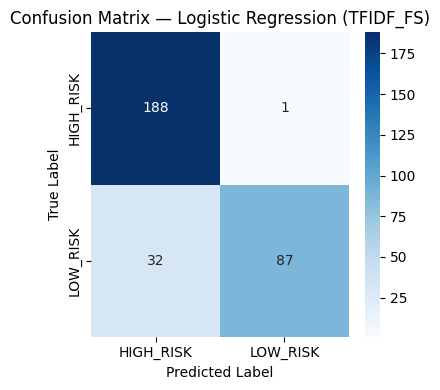

📁 Hasil prediksi disimpan di: /content/Result_Logistic_Regression_TFIDF_FS_Demographic.csv
❌ Jumlah prediksi salah: 33 (disimpan di /content/Error_Logistic_Regression_TFIDF_FS_Demographic.csv)

🔍 Contoh kesalahan prediksi:


,text,true_label,predicted_label
8,pasien id patient 60-79 berjenis kelamin perem...,LOW_RISK,HIGH_RISK
32,pasien patienttoken pria berusia 20-39 ras dir...,LOW_RISK,HIGH_RISK
33,pasien patienttoken perempuan ras disebutkan60...,LOW_RISK,HIGH_RISK
37,pasien patienttoken patient pria ras disebutka...,LOW_RISK,HIGH_RISK
47,pasien patienttoken laki-laki kulit putih beru...,LOW_RISK,HIGH_RISK



🔹 MODEL: Naive Bayes | FITUR: TFIDF_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.7421    0.9894    0.8481       189
    LOW_RISK     0.9643    0.4538    0.6171       119

    accuracy                         0.7825       308
   macro avg     0.8532    0.7216    0.7326       308
weighted avg     0.8279    0.7825    0.7588       308



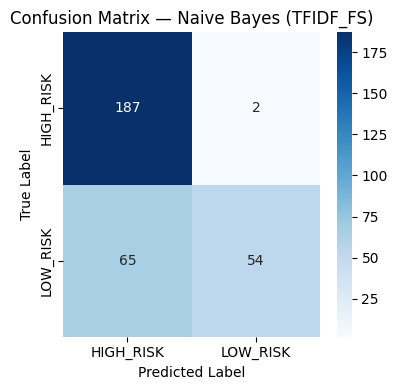

📁 Hasil prediksi disimpan di: /content/Result_Naive_Bayes_TFIDF_FS_Demographic.csv
❌ Jumlah prediksi salah: 67 (disimpan di /content/Error_Naive_Bayes_TFIDF_FS_Demographic.csv)

🔍 Contoh kesalahan prediksi:


,text,true_label,predicted_label
0,patienttoken laki-laki berusia 60-79 ras kelom...,LOW_RISK,HIGH_RISK
8,pasien id patient 60-79 berjenis kelamin perem...,LOW_RISK,HIGH_RISK
18,pasien patienttoken pria berusia 40-59 ras pas...,LOW_RISK,HIGH_RISK
20,pasien patienttoken wanita berkulit putih beru...,LOW_RISK,HIGH_RISK
22,pasien patienttoken pria ras disebutkan20-39 p...,LOW_RISK,HIGH_RISK



####################################################################################################
📂 Memuat fitur: BIGRAM_FS dari /content/SelectedFeatures_NGRAM.csv
🚨 Error saat memproses BIGRAM_FS: [Errno 2] No such file or directory: '/content/SelectedFeatures_NGRAM.csv'


In [ ]:
# =========================================================
# 🧪 UJI MODEL — DEMOGRAPHIC DATA (Versi Lengkap & FINAL)
# =========================================================
# ✅ Aman dari error "could not convert string to float"
# ✅ Menyimpan hasil prediksi lengkap (true_label, predicted_label, text)
# ✅ Siap digunakan untuk analisis error
# =========================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import os

# === 1️⃣ Load dataset utama (dengan teks & label) ===
df = pd.read_csv("/content/demographics_with_qi_labels.csv")
X_text = df["clean_text"].astype(str)
y = df["label"].astype(str)

# === 2️⃣ Path hasil Feature Selection ===
SET_FEATURES = {
    "BoW_FS": "/content/SelectedFeatures_BOW.csv",
    "TFIDF_FS": "/content/TFIDF_demographics.csv",
    "BIGRAM_FS": "/content/SelectedFeatures_NGRAM.csv",
}

# === 3️⃣ Model yang diuji ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "Naive Bayes": MultinomialNB(),
}

# === 4️⃣ Loop semua kombinasi fitur & model ===
for feat_name, feat_path in SET_FEATURES.items():
    print(f"\n{'#'*100}")
    print(f"📂 Memuat fitur: {feat_name} dari {feat_path}")

    try:
        # === Load file fitur hasil seleksi ===
        X_df = pd.read_csv(feat_path)

        # Bersihkan kolom non-numerik / indeks
        if X_df.columns[0].lower() in ['unnamed: 0', '0', 'index']:
            print(f"⚠️ Menghapus kolom indeks: {X_df.columns[0]}")
            X_df = X_df.drop(columns=[X_df.columns[0]])

        non_numeric_cols = X_df.select_dtypes(exclude=['number']).columns.tolist()
        if non_numeric_cols:
            print(f"⚠️ Menghapus kolom non-numerik: {non_numeric_cols}")
            X_df = X_df.drop(columns=non_numeric_cols)

        # Jika belum numerik, paksa konversi
        if X_df.select_dtypes(include=['number']).empty:
            print("⚠️ Tidak ada kolom numerik — mencoba konversi manual...")
            X_df = X_df.apply(pd.to_numeric, errors='coerce')
            X_df = X_df.dropna(axis=1, how='all')

        if X_df.shape[1] == 0:
            print(f"⛔ File {feat_path} tidak memiliki fitur valid. Dilewati.")
            continue

        X = X_df.values

        # === Split data ===
        X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
            X, y, X_text, test_size=0.2, random_state=42, stratify=y
        )

        # === Jalankan semua model ===
        for model_name, model in models.items():
            print(f"\n{'='*100}")
            print(f"🔹 MODEL: {model_name} | FITUR: {feat_name}")
            print(f"{'='*100}")

            # Latih model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # === Classification Report ===
            print("\n📋 Classification Report:")
            print(classification_report(y_test, y_pred, digits=4))

            # === Confusion Matrix ===
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(4,4))
            sns.heatmap(
                cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(df['label'].unique()),
                yticklabels=sorted(df['label'].unique())
            )
            plt.title(f"Confusion Matrix — {model_name} ({feat_name})")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.tight_layout()
            plt.show()

            # === Simpan hasil prediksi (dengan teks) ===
            df_pred = pd.DataFrame({
                "text": text_test.values,
                "true_label": y_test.values,
                "predicted_label": y_pred
            })

            result_path = f"/content/Result_{model_name.replace(' ','_')}_{feat_name}_Demographic.csv"
            error_path  = f"/content/Error_{model_name.replace(' ','_')}_{feat_name}_Demographic.csv"

            df_pred.to_csv(result_path, index=False, encoding="utf-8-sig")

            # Simpan hanya error
            df_err = df_pred[df_pred["true_label"] != df_pred["predicted_label"]]
            df_err.to_csv(error_path, index=False, encoding="utf-8-sig")

            print(f"📁 Hasil prediksi disimpan di: {result_path}")
            print(f"❌ Jumlah prediksi salah: {len(df_err)} (disimpan di {error_path})")

            # Tampilkan contoh error (jika ada)
            if not df_err.empty:
                print("\n🔍 Contoh kesalahan prediksi:")
                display(df_err.head(5))
            else:
                print("✅ Tidak ada prediksi yang salah pada dataset uji.")

    except Exception as e:
        print(f"🚨 Error saat memproses {feat_name}: {e}")
        continue


##Deep Learning

In [ ]:
!pip install -q transformers accelerate peft evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
# ===============================================================
# DEMOGRAPHIC DEEP LEARNING — IMPORT & KONFIGURASI
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model
import evaluate

# 🔁 Seed supaya hasil stabil
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# ⚙️ Konfigurasi LITE (lebih hemat RAM)
MAX_WORDS = 8000      # sebelumnya 20000
MAX_LEN   = 120       # sebelumnya 150
EMBED_DIM = 64        # sebelumnya 256

print("Konfigurasi LITE:")
print("MAX_WORDS =", MAX_WORDS)
print("MAX_LEN   =", MAX_LEN)
print("EMBED_DIM =", EMBED_DIM)


Konfigurasi LITE:
MAX_WORDS = 8000
MAX_LEN   = 120
EMBED_DIM = 64


In [ ]:
# =========================================================
# LOAD DATASET DEMOGRAPHIC & ENCODE LABEL
# =========================================================

df_demo = pd.read_csv("/content/demographics_with_qi_labels.csv")

assert "clean_text" in df_demo.columns
assert "label" in df_demo.columns

df_demo["clean_text"] = df_demo["clean_text"].fillna("").astype(str)

# Encode HIGH_RISK / LOW_RISK → 0 / 1
le = LabelEncoder()
df_demo["label_id"] = le.fit_transform(df_demo["label"])

print("Kelas:", list(le.classes_))
print(df_demo["label_id"].value_counts())

texts_demo  = df_demo["clean_text"].tolist()
labels_demo = df_demo["label_id"].tolist()

X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
    texts_demo,
    labels_demo,
    test_size=0.2,
    stratify=labels_demo,
    random_state=SEED
)

print("Train =", len(X_train_demo), " | Test =", len(X_test_demo))


Kelas: ['HIGH_RISK', 'LOW_RISK']
label_id
0    943
1    597
Name: count, dtype: int64
Train = 1232  | Test = 308


In [ ]:
# =========================================================
# TOKENIZER & PADDING — DEMOGRAPHIC
# =========================================================

tokenizer_demo = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token="<OOV>")
tokenizer_demo.fit_on_texts(X_train_demo)

X_train_demo_seq = pad_sequences(
    tokenizer_demo.texts_to_sequences(X_train_demo),
    maxlen=MAX_LEN,
    padding="post"
)
X_test_demo_seq = pad_sequences(
    tokenizer_demo.texts_to_sequences(X_test_demo),
    maxlen=MAX_LEN,
    padding="post"
)

y_train_demo_arr = np.array(y_train_demo)
y_test_demo_arr  = np.array(y_test_demo)

X_train_demo_seq.shape, X_test_demo_seq.shape


((1232, 120), (308, 120))

In [ ]:
# =========================================================
# CLASS WEIGHT — DEMOGRAPHIC
# =========================================================

classes_demo = np.unique(y_train_demo_arr)
cw_values_demo = compute_class_weight(
    class_weight="balanced",
    classes=classes_demo,
    y=y_train_demo_arr
)
class_weights_demo = dict(zip(classes_demo, cw_values_demo))

print("Class Weights (Demographic):", class_weights_demo)


Class Weights (Demographic): {np.int64(0): np.float64(0.8169761273209549), np.int64(1): np.float64(1.288702928870293)}


###RNN

In [ ]:
# =========================================================
# Model RNN sederhana
# Tujuan:
# - Menjadi baseline model berbasis sekuens untuk klasifikasi risiko.
# =========================================================

def build_rnn_demo():
    model = models.Sequential([
        layers.Input(shape=(MAX_LEN,)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)),  # 128 → 32
        layers.Dropout(0.3),
        layers.Bidirectional(layers.SimpleRNN(16)),                         # 64 → 16
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

rnn_demo = build_rnn_demo()
rnn_demo.summary()

print("Training RNN (Demographic)...")
hist_rnn_demo = rnn_demo.fit(
    X_train_demo_seq,
    y_train_demo_arr,
    validation_split=0.1,
    epochs=8,               # 12 → 8 (lebih cepat)
    batch_size=32,
    class_weight=class_weights_demo,
    verbose=1
)

pred_rnn_demo_prob = rnn_demo.predict(X_test_demo_seq)
pred_rnn_demo = (pred_rnn_demo_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi RNN:", np.unique(pred_rnn_demo, return_counts=True))
print(classification_report(
    y_test_demo_arr,
    pred_rnn_demo,
    target_names=le.classes_,
    digits=4
))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 64)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 120, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,889 (1.99 MB)

 Trainable params: 521,889 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Training RNN (Demographic)...
Epoch 1/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.4844 - loss: 0.6992 - val_accuracy: 0.5968 - val_loss: 0.6861
Epoch 2/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.5594 - loss: 0.6809 - val_accuracy: 0.6452 - val_loss: 0.6518
Epoch 3/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6488 - loss: 0.6492 - val_accuracy: 0.7177 - val_loss: 0.5907
Epoch 4/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7221 - loss: 0.5814 - val_accuracy: 0.7742 - val_loss: 0.5477
Epoch 5/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7803 - loss: 0.5030 - val_accuracy: 0.7742 - val_loss: 0.4556
Epoch 6/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8568 - loss: 0.3946 - val_accuracy: 0.8306 - val_loss: 0.3831
Epoch 7/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9115 - loss: 0.2268 - val_accuracy: 0.9435 - val_loss: 0.1964
Epoch 8/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9727 - loss: 0.0

###LSTM

In [ ]:
# =========================================================
# Model LSTM
# Tujuan:
# - Menggunakan memori jangka panjang untuk data sekuensial.
# =========================================================

def build_lstm_demo():
    model = models.Sequential([
        layers.Input(shape=(MAX_LEN,)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),  # 128 → 32
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(16)),                         # 64 → 16
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_demo = build_lstm_demo()
lstm_demo.summary()

print("Training LSTM (Demographic)...")
hist_lstm_demo = lstm_demo.fit(
    X_train_demo_seq,
    y_train_demo_arr,
    validation_split=0.1,
    epochs=10,              # 15 → 10
    batch_size=32,
    class_weight=class_weights_demo,
    verbose=1
)

pred_lstm_demo_prob = lstm_demo.predict(X_test_demo_seq)
pred_lstm_demo = (pred_lstm_demo_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi LSTM:", np.unique(pred_lstm_demo, return_counts=True))
print(classification_report(
    y_test_demo_arr,
    pred_lstm_demo,
    target_names=le.classes_,
    digits=4
))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 64)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 120, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,289 (2.09 MB)

 Trainable params: 548,289 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Training LSTM (Demographic)...
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 404ms/step - accuracy: 0.4096 - loss: 0.6963 - val_accuracy: 0.7097 - val_loss: 0.6897
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.5880 - loss: 0.6868 - val_accuracy: 0.7581 - val_loss: 0.5969
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.7389 - loss: 0.5810 - val_accuracy: 0.8226 - val_loss: 0.3804
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.8644 - loss: 0.3733 - val_accuracy: 0.9355 - val_loss: 0.2184
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.9478 - loss: 0.1762 - val_accuracy: 0.9355 - val_loss: 0.1735
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9617 - loss: 0.1240 - val_accuracy: 0.8629 - val_loss: 0.3872
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9463 - loss: 0.1463 - val_accuracy: 0.9597 - val_loss: 0.0935
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.9

###Fine Tunning

In [ ]:
# =========================================================
# Fine-Tuned LSTM
# Tujuan:
# - Menggunakan embedding berdimensi lebih tinggi.
# - Meningkatkan kapasitas model untuk menangkap konteks risiko QI.
# =========================================================

def to_pad_demo(texts, mlen):
    seq = tokenizer_demo.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=mlen, padding="post")

# Search space diperkecil: tetap 2 config, tapi units kecil
search_space_demo = [
    {"max_len": 120, "u1": 32, "u2": 16},
    {"max_len": 150, "u1": 32, "u2": 16},
]

X_train_ft_demo, X_val_ft_demo, y_train_ft_demo, y_val_ft_demo = train_test_split(
    X_train_demo, y_train_demo,
    test_size=0.1,
    stratify=y_train_demo,
    random_state=SEED
)

best_cfg_demo = None
best_acc_demo = 0.0

for cfg in search_space_demo:
    print("\nTesting config (Demographic):", cfg)
    Xtr = to_pad_demo(X_train_ft_demo, cfg["max_len"])
    Xv  = to_pad_demo(X_val_ft_demo,  cfg["max_len"])

    model = models.Sequential([
        layers.Input(shape=(cfg["max_len"],)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.LSTM(cfg["u1"], return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(cfg["u2"])),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr, np.array(y_train_ft_demo),
        validation_data=(Xv, np.array(y_val_ft_demo)),
        epochs=3,          # 8 → 3 (cuma untuk cari config)
        batch_size=32,
        class_weight=class_weights_demo,
        verbose=0
    )

    acc = max(hist.history["val_accuracy"])
    print("Best val acc:", acc)

    if acc > best_acc_demo:
        best_acc_demo = acc
        best_cfg_demo = cfg

print("\nConfig terbaik (Demographic):", best_cfg_demo)
print("Val Accuracy terbaik:", best_acc_demo)

# ===== Train FT-LSTM final =====
X_train_final_demo = to_pad_demo(X_train_demo, best_cfg_demo["max_len"])
X_test_final_demo  = to_pad_demo(X_test_demo,  best_cfg_demo["max_len"])

ft_lstm_demo = models.Sequential([
    layers.Input(shape=(best_cfg_demo["max_len"],)),
    layers.Embedding(MAX_WORDS, EMBED_DIM),
    layers.Bidirectional(layers.LSTM(best_cfg_demo["u1"], return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(best_cfg_demo["u2"])),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

ft_lstm_demo.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop_demo = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

print("Training FT-LSTM final (Demographic)...")
hist_ft_demo = ft_lstm_demo.fit(
    X_train_final_demo,
    y_train_demo_arr,
    validation_split=0.1,
    epochs=8,            # 20 → 8
    batch_size=32,
    class_weight=class_weights_demo,
    callbacks=[early_stop_demo],
    verbose=1
)

pred_ft_demo_prob = ft_lstm_demo.predict(X_test_final_demo)
pred_ft_demo = (pred_ft_demo_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi FT-LSTM:", np.unique(pred_ft_demo, return_counts=True))
print(classification_report(
    y_test_demo_arr,
    pred_ft_demo,
    target_names=le.classes_,
    digits=4
))



Testing config (Demographic): {'max_len': 120, 'u1': 32, 'u2': 16}
Best val acc: 0.9032257795333862

Testing config (Demographic): {'max_len': 150, 'u1': 32, 'u2': 16}
Best val acc: 0.8870967626571655

Config terbaik (Demographic): {'max_len': 120, 'u1': 32, 'u2': 16}
Val Accuracy terbaik: 0.9032257795333862
Training FT-LSTM final (Demographic)...
Epoch 1/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - accuracy: 0.4724 - loss: 0.6957 - val_accuracy: 0.6048 - val_loss: 0.6686
Epoch 2/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - accuracy: 0.6722 - loss: 0.6637 - val_accuracy: 0.7903 - val_loss: 0.5004
Epoch 3/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.7731 - loss: 0.5183 - val_accuracy: 0.7097 - val_loss: 0.5654
Epoch 4/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.7675 - loss: 0.5477 - val_accuracy: 0.8145 - val_loss: 0.4215
Epoch 5/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 388ms/step - accuracy: 0.8177 - loss: 0.4641 - val_accuracy: 0.8548 - val_loss: 0.3638
Epoch 6/8

###LoRa

In [ ]:
# =========================================================
# Persiapan LoRA BERT (Ultra Lite)
# Tujuan:
# - Menggunakan representasi bahasa pretrained.
# - Melakukan fine-tuning parameter efisien (LoRA).
# =========================================================


tokenizer_lora_demo = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

class TextDatasetDemo(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds_demo = TextDatasetDemo(X_train_demo, y_train_demo, tokenizer_lora_demo, max_len=128)
test_ds_demo  = TextDatasetDemo(X_test_demo,  y_test_demo,  tokenizer_lora_demo, max_len=128)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device LoRA Demographic:", device)

base_model_demo = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=2
)

lora_cfg_demo = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin"],
    task_type="SEQ_CLS"
)

lora_model_demo = get_peft_model(base_model_demo, lora_cfg_demo).to(device)

metric_demo = evaluate.load("accuracy")

def compute_metrics_demo(p):
    logits, labels = p
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric_demo.compute(predictions=preds, references=labels)["accuracy"]}

args_demo = TrainingArguments(
    output_dir="lora_out_demo",
    learning_rate=5e-5,
    per_device_train_batch_size=4,   # 8 → 4 (hemat RAM)
    per_device_eval_batch_size=8,    # 16 → 8
    num_train_epochs=3,              # 5 → 3
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=20,
    report_to=[]
)

trainer_demo = Trainer(
    model=lora_model_demo,
    args=args_demo,
    train_dataset=train_ds_demo,
    eval_dataset=test_ds_demo,
    compute_metrics=compute_metrics_demo
)

trainer_demo.train()

output_demo = trainer_demo.predict(test_ds_demo)
pred_lora_demo = np.argmax(output_demo.predictions, axis=1)

print("Distribusi prediksi LoRA:", np.unique(pred_lora_demo, return_counts=True))
print(classification_report(
    y_test_demo_arr,
    pred_lora_demo,
    target_names=le.classes_,
    digits=4
))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Device LoRA Demographic: cpu


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.531400,0.558283,0.766234
2,0.505300,0.467287,0.821429
3,0.413900,0.453611,0.837662


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Distribusi prediksi LoRA: (array([0, 1]), array([223,  85]))
              precision    recall  f1-score   support

   HIGH_RISK     0.8117    0.9577    0.8786       189
    LOW_RISK     0.9059    0.6471    0.7549       119

    accuracy                         0.8377       308
   macro avg     0.8588    0.8024    0.8168       308
weighted avg     0.8481    0.8377    0.8308       308



###Summary Hasil

,Accuracy,F1
RNN,0.941558,0.940906
LSTM,0.964286,0.964501
FT-LSTM,0.964286,0.964257
LoRA-BERT,0.837662,0.830833


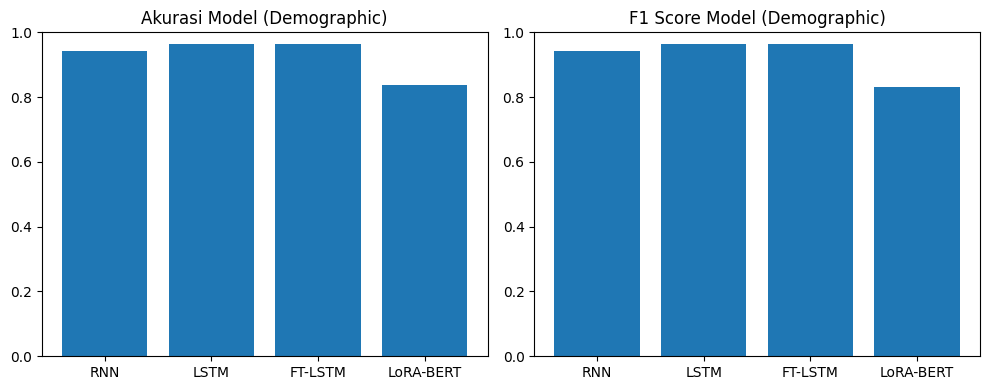

In [ ]:
# =========================================================
# RINGKASAN HASIL — DEMOGRAPHIC
# =========================================================

summary_demo = {
    "RNN": {
        "Accuracy": accuracy_score(y_test_demo_arr, pred_rnn_demo),
        "F1": f1_score(y_test_demo_arr, pred_rnn_demo, average="weighted")
    },
    "LSTM": {
        "Accuracy": accuracy_score(y_test_demo_arr, pred_lstm_demo),
        "F1": f1_score(y_test_demo_arr, pred_lstm_demo, average="weighted")
    },
    "FT-LSTM": {
        "Accuracy": accuracy_score(y_test_demo_arr, pred_ft_demo),
        "F1": f1_score(y_test_demo_arr, pred_ft_demo, average="weighted")
    },
    "LoRA-BERT": {
        "Accuracy": accuracy_score(y_test_demo_arr, pred_lora_demo),
        "F1": f1_score(y_test_demo_arr, pred_lora_demo, average="weighted")
    }
}

df_summary_demo = pd.DataFrame(summary_demo).T
display(df_summary_demo)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(df_summary_demo.index, df_summary_demo["Accuracy"])
plt.title("Akurasi Model (Demographic)")
plt.ylim(0,1)

plt.subplot(1,2,2)
plt.bar(df_summary_demo.index, df_summary_demo["F1"])
plt.title("F1 Score Model (Demographic)")
plt.ylim(0,1)

plt.tight_layout()
plt.show()


##Error Analysis

####################################################################################################
📊 Jumlah kesalahan prediksi untuk semua model & fitur:

Analisis fitur: BoW_FS
   File tidak ditemukan: /content/Result_Logistic_Regression_BoW_FS_Demographic.csv
   File tidak ditemukan: /content/Result_Naive_Bayes_BoW_FS_Demographic.csv
----------------------------------------------------------------------------------------------------
Analisis fitur: TFIDF_FS
   • Logistic Regression : 33 dari 308 data (10.71%)
   • Naive Bayes         : 67 dari 308 data (21.75%)
----------------------------------------------------------------------------------------------------
Analisis fitur: BIGRAM_FS
   File tidak ditemukan: /content/Result_Logistic_Regression_BIGRAM_FS_Demographic.csv
   File tidak ditemukan: /content/Result_Naive_Bayes_BIGRAM_FS_Demographic.csv
----------------------------------------------------------------------------------------------------

Contoh kesalahan prediksi — Logis

,text,true_label,predicted_label,is_correct
8,pasien id patient 60-79 berjenis kelamin perem...,LOW_RISK,HIGH_RISK,False
32,pasien patienttoken pria berusia 20-39 ras dir...,LOW_RISK,HIGH_RISK,False
33,pasien patienttoken perempuan ras disebutkan60...,LOW_RISK,HIGH_RISK,False
37,pasien patienttoken patient pria ras disebutka...,LOW_RISK,HIGH_RISK,False
47,pasien patienttoken laki-laki kulit putih beru...,LOW_RISK,HIGH_RISK,False
49,pasien patienttoken wanita berusia 20-39 ras d...,LOW_RISK,HIGH_RISK,False
51,pasien patienttoken patient perempuan berusia ...,LOW_RISK,HIGH_RISK,False
55,pasien pria kulit hitam berusia 60-79 status e...,LOW_RISK,HIGH_RISK,False
60,pasien id patient berusia 40-59 berjenis kelam...,LOW_RISK,HIGH_RISK,False
62,pasien patienttoken pria ras disebutkan40-59 s...,LOW_RISK,HIGH_RISK,False



 Kata paling sering muncul dalam prediksi salah — Logistic Regression (TFIDF_FS):


,Kata,Frekuensi
0,penyakit,131
1,pasien,97
2,gagal,62
3,ginjal,62
4,kronis,62
5,jam,60
6,hospitaltoken,42
7,riwayat,34
8,memiliki,32
9,hiperlipidemia,31


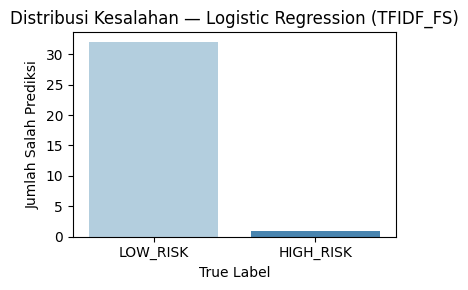


Contoh kesalahan prediksi — Naive Bayes (TFIDF_FS)


,text,true_label,predicted_label,is_correct
0,patienttoken laki-laki berusia 60-79 ras kelom...,LOW_RISK,HIGH_RISK,False
8,pasien id patient 60-79 berjenis kelamin perem...,LOW_RISK,HIGH_RISK,False
18,pasien patienttoken pria berusia 40-59 ras pas...,LOW_RISK,HIGH_RISK,False
20,pasien patienttoken wanita berkulit putih beru...,LOW_RISK,HIGH_RISK,False
22,pasien patienttoken pria ras disebutkan20-39 p...,LOW_RISK,HIGH_RISK,False
30,patienttoken laki-laki berusia 60-79 ras kelom...,LOW_RISK,HIGH_RISK,False
32,pasien patienttoken pria berusia 20-39 ras dir...,LOW_RISK,HIGH_RISK,False
33,pasien patienttoken perempuan ras disebutkan60...,LOW_RISK,HIGH_RISK,False
34,pasien patienttoken laki-laki kulit putih beru...,LOW_RISK,HIGH_RISK,False
37,pasien patienttoken patient pria ras disebutka...,LOW_RISK,HIGH_RISK,False



 Kata paling sering muncul dalam prediksi salah — Naive Bayes (TFIDF_FS):


,Kata,Frekuensi
0,penyakit,254
1,pasien,206
2,gagal,120
3,ginjal,120
4,kronis,120
5,jam,94
6,memiliki,84
7,hospitaltoken,75
8,riwayat,72
9,hiperlipidemia,60


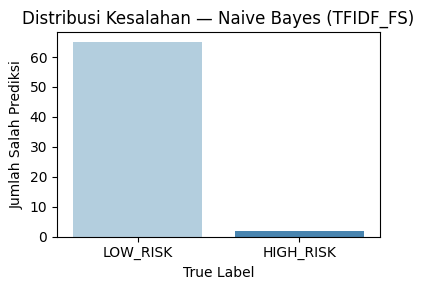


 Ringkasan analisis error disimpan di: /content/Error_Analysis_Summary_AllFeatures.csv


,Fitur,Model,Total Data Uji,Jumlah Error,Persentase Error (%)
0,TFIDF_FS,Logistic Regression,308,33,10.71
1,TFIDF_FS,Naive Bayes,308,67,21.75


In [ ]:
# =========================================================
# NAALISIS ERROR — SEMUA PENDEKATAN FITUR (BoW, TF-IDF, Bigram)
# =========================================================
# 1️ Loop otomatis semua kombinasi model + fitur
# 2️ Tampilkan jumlah error, contoh kesalahan, dan kata dominan
# 3️ Visualisasi distribusi kesalahan
# 4️ Simpan ringkasan lengkap ke CSV
# =========================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

# === Semua kombinasi hasil prediksi ===
RESULT_FILES = {
    "BoW_FS": {
        "Logistic Regression": "/content/Result_Logistic_Regression_BoW_FS_Demographic.csv",
        "Naive Bayes": "/content/Result_Naive_Bayes_BoW_FS_Demographic.csv",
    },
    "TFIDF_FS": {
        "Logistic Regression": "/content/Result_Logistic_Regression_TFIDF_FS_Demographic.csv",
        "Naive Bayes": "/content/Result_Naive_Bayes_TFIDF_FS_Demographic.csv",
    },
    "BIGRAM_FS": {
        "Logistic Regression": "/content/Result_Logistic_Regression_BIGRAM_FS_Demographic.csv",
        "Naive Bayes": "/content/Result_Naive_Bayes_BIGRAM_FS_Demographic.csv",
    }
}

# ===  Fungsi bantu ===
def common_words(df, col="text", topn=15):
    if col not in df.columns:
        return pd.DataFrame(columns=["Kata", "Frekuensi"])
    all_text = " ".join(df[col].astype(str).tolist()).lower().split()
    common = Counter(all_text).most_common(topn)
    return pd.DataFrame(common, columns=["Kata", "Frekuensi"])

def plot_error_distribution(df, model_name, feat_name):
    plt.figure(figsize=(4,3))
    sns.countplot(x="true_label", data=df, hue="true_label", palette="Blues", legend=False)
    plt.title(f"Distribusi Kesalahan — {model_name} ({feat_name})")
    plt.xlabel("True Label")
    plt.ylabel("Jumlah Salah Prediksi")
    plt.tight_layout()
    plt.show()

# === Analisis semua kombinasi ===
summary_rows = []

print("#" * 100)
print("📊 Jumlah kesalahan prediksi untuk semua model & fitur:\n")

for feat_name, models in RESULT_FILES.items():
    print(f"Analisis fitur: {feat_name}")
    for model_name, path in models.items():
        if not os.path.exists(path):
            print(f"   File tidak ditemukan: {path}")
            continue

        res = pd.read_csv(path)
        res["is_correct"] = res["true_label"] == res["predicted_label"]
        err_df = res[~res["is_correct"]]

        total = len(res)
        errors = len(err_df)
        err_percent = errors / total * 100

        print(f"   • {model_name:<20}: {errors} dari {total} data ({err_percent:.2f}%)")

        summary_rows.append({
            "Fitur": feat_name,
            "Model": model_name,
            "Total Data Uji": total,
            "Jumlah Error": errors,
            "Persentase Error (%)": round(err_percent, 2)
        })
    print("-" * 100)

# === Contoh kesalahan & kata dominan ===
for feat_name, models in RESULT_FILES.items():
    for model_name, path in models.items():
        if not os.path.exists(path):
            continue

        print(f"\n{'='*100}")
        print(f"Contoh kesalahan prediksi — {model_name} ({feat_name})")
        print(f"{'='*100}")

        res = pd.read_csv(path)
        res["is_correct"] = res["true_label"] == res["predicted_label"]
        err_df = res[~res["is_correct"]]

        # Contoh kesalahan
        if "text" in err_df.columns:
            display(err_df.head(10)[["text", "true_label", "predicted_label", "is_correct"]])
        else:
            print("Kolom 'text' tidak ditemukan. Menampilkan label saja.\n")
            display(err_df.head(10)[["true_label", "predicted_label", "is_correct"]])

        # Kata paling sering
        print(f"\n Kata paling sering muncul dalam prediksi salah — {model_name} ({feat_name}):")
        display(common_words(err_df, col="text", topn=15))

        # Distribusi kesalahan
        if not err_df.empty:
            plot_error_distribution(err_df, model_name, feat_name)

# === Simpan ringkasan akhir ===
summary = pd.DataFrame(summary_rows)
summary_path = "/content/Error_Analysis_Summary_AllFeatures.csv"
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")

print(f"\n Ringkasan analisis error disimpan di: {summary_path}")
display(summary)


#**CLINICAL DATASET**

##Anonimisasi

In [ ]:
# =========================================================
# Anonimisasi teks rekam medis
# Sumber  : ClinicalData_serialisasi.csv
# Output  : ClinicalData_anonymized.csv
# =========================================================

"""#**CLINICAL DATASET**

##Anonimisasi
"""

import re
import pandas as pd
import random
from hashlib import blake2b
import csv

# === 1. Baca dataset dengan mode aman ===
csv_path = "/content/ClinicalData_serialisasi.csv"

try:
    # Coba baca dengan koma dulu
    df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
except Exception:
    # Jika gagal, coba baca dengan delimiter titik koma
    df = pd.read_csv(csv_path, sep=';', on_bad_lines='skip', engine='python')

print("✅ Dataset berhasil dibaca!")
print("📄 Jumlah baris:", len(df))
print("📊 Kolom dataset:", df.columns.tolist())

# === 2. Tentukan kolom teks yang akan dianonimkan ===
text_column = "text_serialized"
if text_column not in df.columns:
    raise ValueError(f"❌ Kolom '{text_column}' tidak ditemukan di dataset.")

# === 3. Fungsi pseudonimisasi (hash pendek) ===
def pseudo_token(value, prefix):
    h = blake2b(value.encode(), digest_size=2).hexdigest().upper()
    return f"{prefix}_{h}"

# === 4. Fungsi generalisasi ===
def generalize_age(text):
    match = re.search(r'(berusia|umur)\s*(\d{1,3})\s*tahun', text)
    if match:
        age = int(match.group(2))
        if age < 20:
            r = "0–19 tahun"
        elif age < 40:
            r = "20–39 tahun"
        elif age < 60:
            r = "40–59 tahun"
        elif age < 80:
            r = "60–79 tahun"
        else:
            r = "80–99 tahun"
        text = re.sub(r'(berusia|umur)\s*\d{1,3}\s*tahun', f"berusia {r}", text)
    return text

def generalize_number(text):
    text = re.sub(r'\d+\.\d+\s*(cm|kg|mL|menit)', r"<angka_tersembunyi> \1", text)
    text = re.sub(r'\d+\s*(cm|kg|mL|menit)', r"<angka_tersembunyi> \1", text)
    text = re.sub(r'\d+\.\d+', "<angka_tersembunyi>", text)
    return text

def generalize_time(text):
    return re.sub(r'(durasi|lama)\s+[a-z\s]*\s*\d+\s*menit', r'\1 disamarkan', text, flags=re.IGNORECASE)

# === 5. Perturbasi (L-diversity) ===
def perturb_sensitive(text):
    variants = {
        "hipertensi": random.choice(["tekanan darah tinggi", "hipertensi ringan"]),
        "diabetes mellitus": random.choice(["kadar gula tinggi", "diabetes ringan"]),
        "kanker rektal": random.choice(["kanker saluran pencernaan bawah", "tumor rektum"]),
        "kanker lambung": random.choice(["kanker saluran pencernaan atas", "tumor lambung"]),
        "batu empedu": random.choice(["kelainan empedu", "gangguan kantung empedu"]),
        "meninggal": random.choice(["tidak selamat", "deceased"]),
        "tidak meninggal": "selamat dan pulih",
    }
    for k, v in variants.items():
        text = re.sub(k, v, text, flags=re.IGNORECASE)
    return text

# === 6. Fungsi utama anonimisasi ===
def anonymize_text(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\s+', ' ', text.strip())

    # --- Pseudonymization ---
    text = re.sub(
        r'(?i)nomor identifikasi\s*(\d+)',
        lambda m: pseudo_token(m.group(1), "Patient"),
        text
    )

    # --- Generalisasi ---
    text = generalize_age(text)
    text = generalize_number(text)
    text = generalize_time(text)

    # --- Perturbation ---
    text = perturb_sensitive(text)

    return text

# === 7. Terapkan fungsi anonimisasi ===
df["text_anonymized"] = df[text_column].apply(anonymize_text)
df["text_anonymized"] = df["text_anonymized"].replace({r'\n': ' '}, regex=True)

# === 8. Simpan hasil ===
out_path = "/content/ClinicalData_anonymized.csv"
df[["text_anonymized"]].to_csv(out_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_MINIMAL)

print(f"\n✅ Hasil anonimisasi disimpan di: {out_path}")
print("\n📄 Contoh hasil:\n")
print(df["text_anonymized"].head(5))


✅ Dataset berhasil dibaca!
📄 Jumlah baris: 6388
📊 Kolom dataset: ['text_serialized']

✅ Hasil anonimisasi disimpan di: /content/ClinicalData_anonymized.csv

📄 Contoh hasil:

0    Pasien dengan Patient_CE17 adalah seorang pria...
1    Pasien dengan Patient_7056 adalah seorang pria...
2    Pasien dengan Patient_8AC4 adalah seorang pria...
3    Pasien dengan Patient_687D adalah seorang pria...
4    Pasien dengan Patient_2084 adalah seorang pria...
Name: text_anonymized, dtype: object


##Preprocessing

In [ ]:
# =========================================================
# Preprocessing teks teranonim
# Sumber  : ClinicalData_anonymized.csv
# Output  : ClinicalData_preprocessed.csv (kolom clean_text)
# =========================================================

"""##Preprocessing"""

import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# === 1. Download stopword ===
nltk.download("stopwords")

# === 2. Baca dataset hasil anonimisasi ===
df = pd.read_csv("/content/ClinicalData_anonymized.csv")
print(f"Jumlah data: {len(df)} baris\n")

# Pastikan kolom teks benar
text_column = "text_anonymized"
print("Kolom:", df.columns.tolist())

# === 3. Siapkan stopword ===
stopwords_id = set(stopwords.words("indonesian"))
stopwords_en = set(stopwords.words("english"))
custom_stop = {
    "yang", "dan", "di", "ke", "dari", "pada", "untuk", "dengan", "adalah",
    "seorang", "dalam", "oleh", "itu", "ini", "hari", "bulan", "pukul",
    "sekitar", "tersebut", "dapat", "tanpa", "selama", "tidak", "akan",
    "ialah", "adalah", "yaitu", "yakni", "serta", "juga"
}
# “tahun” tidak dihapus agar konteks umur tetap
stop_words = stopwords_id.union(stopwords_en).union(custom_stop)

# === 4. Fungsi preprocessing ===
def preprocess_clinical_text(text):
    if pd.isna(text):
        return ""

    # 1. Lowercase teks
    text = text.lower()

    # 2. Normalisasi tanda hubung unicode
    text = text.replace("–", "-").replace("—", "-")

    # 3. Tokenisasi untuk placeholder anonimisasi
    text = re.sub(r'patient_[a-z0-9]+', 'patienttoken', text)
    text = re.sub(r'hospital_[a-z0-9]+', 'hospitaltoken', text)
    text = re.sub(r'<angka_tersembunyi>', 'numtoken', text)

    # 4. Bersihkan simbol non-alfanumerik
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)

    # 5. Hapus stopword namun pertahankan angka penting
    tokens = []
    for w in text.split():
        if w not in stop_words and not re.match(r'^\d+$', w):
            tokens.append(w)

    text = " ".join(tokens)

    # 6. Gabungkan format umur seperti "60-79"
    text = re.sub(r'(\d{1,3})-(\d{1,3})', r'\1-\2', text)

    # 7. Hapus unit standar yang tidak relevan
    text = re.sub(r'\b(cm|kg|ml|menit)\b', '', text)

    # 8. Perbaiki spasi ganda
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# === 5. Terapkan ke seluruh dataset ===
df["clean_text"] = df[text_column].astype(str).apply(preprocess_clinical_text)

# === 6. Simpan hasil ===
out_path = "/content/ClinicalData_preprocessed.csv"
df[["clean_text"]].to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"Preprocessing selesai! Hasil disimpan di: {out_path}")
print("\nContoh hasil:")
print(df["clean_text"].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Jumlah data: 6388 baris

Kolom: ['text_anonymized']
Preprocessing selesai! Hasil disimpan di: /content/ClinicalData_preprocessed.csv

Contoh hasil:
0    pasien patienttoken pria berusia 60-79 numtoke...
1    pasien patienttoken pria berusia 40-59 numtoke...
2    pasien patienttoken pria berusia 60-79 numtoke...
Name: clean_text, dtype: object


##QI Weak Labelling

In [ ]:
# =========================================================
# Weak labeling berbasis QI
# Sumber  : ClinicalData_preprocessed.csv
# Output  : ClinicalData_with_qi_labels.csv (qi_score, label)
# =========================================================

"""##Import Konfig"""

# =========================================================
# CLINICAL — IMPORT & KONFIGURASI
# =========================================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

plt.rcParams["figure.figsize"] = (4.8, 4.0)
RANDOM_STATE = 42

PATH_IN  = "/content/ClinicalData_preprocessed.csv"
PATH_OUT = "/content/ClinicalData_with_qi_labels.csv"

# =========================================================
# 1. LOAD DATA PREPROSES
# =========================================================
df = pd.read_csv(PATH_IN)
print(" Data preprocessed dimuat.")
print("Jumlah baris:", len(df))
print(df.head(3))

# Jika kolom baru muncul
if "text_anonymized" in df.columns and "clean_text" not in df.columns:
    df = df.rename(columns={"text_anonymized": "clean_text"})

assert "clean_text" in df.columns, "Kolom 'clean_text' tidak ditemukan!"

# =========================================================
# 2. DEFINISI POLA QI UNTUK CLINICAL
# =========================================================
QI_PATTERNS = {
    "age": r"\b(\d{1,2})\s*tahun\b|\b(0–19 tahun|20–39 tahun|40–59 tahun|60–79 tahun|80–99 tahun)\b",
    "time": r"\b(jam|pukul|menit)\b",
    "procedure": r"\b(operasi|pembedahan|tindakan|prosedur)\b",
    "location": r"\b(ruang rawat inap|igd|icu|poli|bangsal)\b",
    "outcome": r"\b(meninggal|deceased|tidak selamat|selamat|pulih)\b",
}

QI_COMPILED = {k: re.compile(v, flags=re.IGNORECASE) for k, v in QI_PATTERNS.items()}

def count_qi(text):
    """Menghitung jumlah kategori QI yang muncul dalam teks klinis."""
    t = str(text).lower()
    score = 0
    for name, rx in QI_COMPILED.items():
        if rx.search(t):
            score += 1
    return score

df["qi_score"] = df["clean_text"].apply(count_qi)

print("\nRingkasan qi_score:")
print(df["qi_score"].describe())
print("\nDistribusi qi_score:")
print(df["qi_score"].value_counts().sort_index())

# =========================================================
# 3. PENENTUAN THRESHOLD OTOMATIS (HIGH / LOW RISK)
# =========================================================
candidates = range(1, 8)
n = len(df)

def balance_metric(th):
    high = (df["qi_score"] >= th).sum()
    prop = high / n
    return abs(prop - 0.5)

best_th = min(candidates, key=balance_metric)

df["label"] = np.where(df["qi_score"] >= best_th, "HIGH_RISK", "LOW_RISK")

print(f"Threshold terpilih: {best_th}")
print("Distribusi label:\n", df["label"].value_counts())

df.to_csv(PATH_OUT, index=False)
print("Disimpan:", PATH_OUT)

# =========================================================
# 4. AUDIT MINI — CEK DATA DI SEKITAR THRESHOLD
# =========================================================
t = int(best_th)
edge = df[(df["qi_score"] >= t-1) & (df["qi_score"] <= t+1)][["clean_text","qi_score","label"]].head(30)

def _short(s, n=220):
    s = str(s)
    return s if len(s) <= n else s[:n] + " ..."

edge_view = edge.copy()
edge_view["clean_text"] = edge_view["clean_text"].apply(_short)
display(edge_view)


 Data preprocessed dimuat.
Jumlah baris: 6388
                                          clean_text
0  pasien patienttoken pria berusia 60-79 numtoke...
1  pasien patienttoken pria berusia 40-59 numtoke...
2  pasien patienttoken pria berusia 60-79 numtoke...

Ringkasan qi_score:
count    6388.000000
mean        2.917345
std         0.650464
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: qi_score, dtype: float64

Distribusi qi_score:
qi_score
0     175
1       4
2     575
3    5054
4     580
Name: count, dtype: int64
Threshold terpilih: 3
Distribusi label:
 label
HIGH_RISK    5634
LOW_RISK      754
Name: count, dtype: int64
Disimpan: /content/ClinicalData_with_qi_labels.csv


,clean_text,qi_score,label
0,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
1,pasien patienttoken pria berusia 40-59 numtoke...,3,HIGH_RISK
2,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
3,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
4,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
5,pasien wanita berusia 60-79 numtoken berat num...,3,HIGH_RISK
6,pasien wanita berusia 40-59 numtoken berat num...,3,HIGH_RISK
7,pasien wanita berusia 80-99 numtoken berat num...,3,HIGH_RISK
8,pasien wanita berusia 20-39 numtoken berat num...,3,HIGH_RISK
9,pasien pria berusia 60-79 numtoken berat numto...,3,HIGH_RISK


In [ ]:
# =========================================================
# AUDIT MINI — CEK DEKAT THRESHOLD
# =========================================================
t = int(best_th)
edge = df[(df["qi_score"] >= t-1) & (df["qi_score"] <= t+1)][["clean_text","qi_score","label"]].head(30)

def _short(s, n=220):
    s = str(s)
    return s if len(s) <= n else s[:n] + " ..."
edge_view = edge.copy()
edge_view["clean_text"] = edge_view["clean_text"].apply(_short)
display(edge_view)


,clean_text,qi_score,label
0,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
1,pasien patienttoken pria berusia 40-59 numtoke...,3,HIGH_RISK
2,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
3,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
4,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
5,pasien wanita berusia 60-79 numtoken berat num...,3,HIGH_RISK
6,pasien wanita berusia 40-59 numtoken berat num...,3,HIGH_RISK
7,pasien wanita berusia 80-99 numtoken berat num...,3,HIGH_RISK
8,pasien wanita berusia 20-39 numtoken berat num...,3,HIGH_RISK
9,pasien pria berusia 60-79 numtoken berat numto...,3,HIGH_RISK


##Pendekatan Fitur

In [ ]:
# =========================================================
# CLINICAL — LOAD DATASET HASIL QI LABELING
# =========================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ganti path sesuai file kamu
PATH = "/content/ClinicalData_with_qi_labels.csv"
df = pd.read_csv(PATH)

print(f"Jumlah data: {len(df)} baris\n")
print("Kolom tersedia:", df.columns.tolist())

# Pastikan kolom clean_text & label ada
assert "clean_text" in df.columns, "Kolom 'clean_text' tidak ditemukan!"
assert "label" in df.columns, "Kolom 'label' tidak ditemukan — pastikan hasil QI sudah dijalankan!"

# Bersihkan data kosong
df["clean_text"] = df["clean_text"].fillna("").astype(str)
display(df.head(5))


# =========================================================
# CLINICAL — SPLIT DATA
# =========================================================
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data latih:", len(X_train))
print("Data uji  :", len(X_test))


Jumlah data: 6388 baris

Kolom tersedia: ['clean_text', 'qi_score', 'label']


,clean_text,qi_score,label
0,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
1,pasien patienttoken pria berusia 40-59 numtoke...,3,HIGH_RISK
2,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
3,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK
4,pasien patienttoken pria berusia 60-79 numtoke...,3,HIGH_RISK


Data latih: 5110
Data uji  : 1278


###BOW

In [ ]:
# =========================================================
# PENDEKATAN FITUR — BAG OF WORDS (CLEANED)
# =========================================================
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# === 1. Load dataset ===
df = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")
print(f"Jumlah data: {len(df)} baris\n")
print("Kolom tersedia:", df.columns.tolist())

# === 2. Vectorizer dengan parameter pembersihan ===
bow_vectorizer = CountVectorizer(
    ngram_range=(1, 1),          # hanya unigram
    min_df=2,                    # minimal muncul di 2 dokumen
    max_df=0.95,                 # maksimal muncul di 95% dokumen
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"  # hanya ambil token huruf (hindari angka seperti 19, 40, 99)
)

X_bow = bow_vectorizer.fit_transform(df["clean_text"])

# === 3. Konversi ke DataFrame ===
bow_df = pd.DataFrame(
    X_bow.toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)

# === 4. Info hasil ===
print(f"Bentuk matriks BoW: {X_bow.shape}")
print("Jumlah fitur:", X_bow.shape[1])
print("Contoh fitur:", bow_vectorizer.get_feature_names_out()[:15])

# === 5. Simpan hasil ===
out_path = "/content/BOW_ClinicalData_cleaned.csv"
bow_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ BoW selesai!\n📁 Disimpan di: {out_path}")
display(bow_df.head(5))


Jumlah data: 6388 baris

Kolom tersedia: ['clean_text', 'qi_score', 'label']
Bentuk matriks BoW: (6388, 1585)
Jumlah fitur: 1585
Contoh fitur: ['abdomen' 'abdominal' 'abdominalis' 'abdominoperineal' 'aberan' 'abg'
 'abnormal' 'abnormalitas' 'abscess' 'abses' 'activated' 'acuminata'
 'acute' 'adenocarcinoma' 'adenokarsinoma']

✅ BoW selesai!
📁 Disimpan di: /content/BOW_ClinicalData_cleaned.csv


,abdomen,abdominal,abdominalis,abdominoperineal,aberan,abg,abnormal,abnormalitas,abscess,abses,...,wanita,wasir,wedge,wide,wilson,without,wound,xanthogranulomatous,ya,zona
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###TF-IDF

In [ ]:
# =========================================================
# PENDEKATAN FITUR — TF-IDF DENGAN FILTER TOKEN
# =========================================================
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# === 1. Load dataset ===
df = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")
print(f"Jumlah data: {len(df)} baris\n")
print("Kolom tersedia:", df.columns.tolist())

# === 2. Vectorizer dengan filter token ===
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),          # unigram
    min_df=2,                    # abaikan kata yang muncul <2 dokumen
    max_df=0.95,                 # abaikan kata terlalu umum (>95% dokumen)
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"  # hanya token huruf (hindari angka seperti '1010')
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

# === 3. Konversi ke DataFrame ===
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# === 4. Info hasil ===
print(f"Bentuk matriks TF-IDF: {X_tfidf.shape}")
print("Jumlah fitur:", X_tfidf.shape[1])
print("Contoh fitur:", tfidf_vectorizer.get_feature_names_out()[:15])

# === 5. Simpan hasil ===
out_path = "/content/TFIDF_ClinicalData.csv"
tfidf_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ TF-IDF selesai!\n📁 Disimpan di: {out_path}")
display(tfidf_df.head(5))


Jumlah data: 6388 baris

Kolom tersedia: ['clean_text', 'qi_score', 'label']
Bentuk matriks TF-IDF: (6388, 1585)
Jumlah fitur: 1585
Contoh fitur: ['abdomen' 'abdominal' 'abdominalis' 'abdominoperineal' 'aberan' 'abg'
 'abnormal' 'abnormalitas' 'abscess' 'abses' 'activated' 'acuminata'
 'acute' 'adenocarcinoma' 'adenokarsinoma']

✅ TF-IDF selesai!
📁 Disimpan di: /content/TFIDF_ClinicalData.csv


,abdomen,abdominal,abdominalis,abdominoperineal,aberan,abg,abnormal,abnormalitas,abscess,abses,...,wanita,wasir,wedge,wide,wilson,without,wound,xanthogranulomatous,ya,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###N-GRAM

In [ ]:
# =========================================================
# PENDEKATAN FITUR — N-GRAM (BIGRAM, CLEANED)
# =========================================================
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# === 1. Load dataset ===
df = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")
print(f"Jumlah data: {len(df)} baris\n")
print("Kolom tersedia:", df.columns.tolist())

# === 2. Vectorizer dengan filter token ===
ngram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),          # ambil pasangan kata (bigram)
    min_df=2,                    # minimal muncul di 2 dokumen
    max_df=0.95,                 # maksimal muncul di 95% dokumen
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"  # hanya ambil kata huruf (hindari angka)
)

X_ngram = ngram_vectorizer.fit_transform(df["clean_text"])

# === 3. Konversi ke DataFrame ===
ngram_df = pd.DataFrame(
    X_ngram.toarray(),
    columns=ngram_vectorizer.get_feature_names_out()
)

# === 4. Info hasil ===
print(f"Bentuk matriks N-gram (Bigram): {X_ngram.shape}")
print("Jumlah fitur:", X_ngram.shape[1])
print("Contoh fitur:", ngram_vectorizer.get_feature_names_out()[:15])

# === 5. Simpan hasil ===
out_path = "/content/NGRAM_ClinicalData_cleaned.csv"
ngram_df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ N-gram (Bigram) selesai!\n📁 Disimpan di: {out_path}")
display(ngram_df.head(5))


Jumlah data: 6388 baris

Kolom tersedia: ['clean_text', 'qi_score', 'label']
Bentuk matriks N-gram (Bigram): (6388, 11423)
Jumlah fitur: 11423
Contoh fitur: ['abdomen departemen' 'abdomen menjalani' 'abdomen nama'
 'abdomen prosedur' 'abdominal aorta' 'abdominal menjalani'
 'abdominal prosedur' 'abdominalis menjalani'
 'abdominoperineal pendekatan' 'abdominoperineal resection' 'abg ph'
 'abg pra' 'abg tersedia' 'abnormal chest' 'abnormal finding']

✅ N-gram (Bigram) selesai!
📁 Disimpan di: /content/NGRAM_ClinicalData_cleaned.csv


,abdomen departemen,abdomen menjalani,abdomen nama,abdomen prosedur,abdominal aorta,abdominal menjalani,abdominal prosedur,abdominalis menjalani,abdominoperineal pendekatan,abdominoperineal resection,...,wound departemen,wound diagnosis,wound others,wound pendekatan,xanthogranulomatous cholecystitis,ya diabetes,ya hasil,ya kadar,ya riwayat,zona marginal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Features Selection

In [ ]:
# =========================================================
# 🎯 FEATURE SELECTION — CHI-SQUARE (BoW)
# =========================================================
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2

# === Load dataset & label ===
df_bow = pd.read_csv("/content/BOW_ClinicalData_cleaned.csv")
df_label = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")

X = df_bow.values
y = df_label["label"].astype(str).values

# === Chi-Square Selection ===
k = min(1000, X.shape[1])
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support()
selected_feats = np.array(df_bow.columns)[mask]

# === Simpan hasil ===
OUT_PATH = "/content/FS_BoW_ClinicalData.csv"
pd.DataFrame(X_selected, columns=selected_feats).to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print(f"✅ Feature Selection (BoW) selesai! → {OUT_PATH}")
print(f"Sebelum: {df_bow.shape} | Sesudah: {X_selected.shape}")
print("🔝 20 fitur teratas:\n", selected_feats[:20])


✅ Feature Selection (BoW) selesai! → /content/FS_BoW_ClinicalData.csv
Sebelum: (6388, 1585) | Sesudah: (6388, 1000)
🔝 20 fitur teratas:
 ['abdominal' 'abdominalis' 'abg' 'abnormalitas' 'abscess' 'abses'
 'activated' 'acute' 'adenokarsinoma' 'adenomatoid' 'adenomatosa'
 'adenomyomatosis' 'adenomyosis' 'adesiolisis' 'adhesiolysis' 'adm'
 'administrasi' 'admisi' 'admission' 'adrenalektomi']


In [ ]:
# =========================================================
# 🎯 FEATURE SELECTION — CHI-SQUARE (TF-IDF)
# =========================================================
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2

# === Load dataset & label ===
df_tfidf = pd.read_csv("/content/TFIDF_ClinicalData.csv")
df_label = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")

X = df_tfidf.values
y = df_label["label"].astype(str).values

# === Chi-Square Selection ===
k = min(1000, X.shape[1])
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support()
selected_feats = np.array(df_tfidf.columns)[mask]

# === Simpan hasil ===
OUT_PATH = "/content/FS_TFIDF_ClinicalData.csv"
pd.DataFrame(X_selected, columns=selected_feats).to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print(f"✅ Feature Selection (TF-IDF) selesai! → {OUT_PATH}")
print(f"Sebelum: {df_tfidf.shape} | Sesudah: {X_selected.shape}")
print("🔝 20 fitur teratas:\n", selected_feats[:20])


✅ Feature Selection (TF-IDF) selesai! → /content/FS_TFIDF_ClinicalData.csv
Sebelum: (6388, 1585) | Sesudah: (6388, 1000)
🔝 20 fitur teratas:
 ['abdominal' 'abdominalis' 'abg' 'abnormalitas' 'abscess' 'abses'
 'activated' 'acute' 'adenokarsinoma' 'adenomatoid' 'adenomatosa'
 'adenomyosis' 'adesiolisis' 'adhesi' 'adhesiolysis' 'adm' 'administrasi'
 'admisi' 'adrenal' 'adrenalektomi']


In [ ]:
# =========================================================
# 🎯 FEATURE SELECTION — CHI-SQUARE (BIGRAM)
# =========================================================
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2

# === Load dataset & label ===
df_bigram = pd.read_csv("/content/NGRAM_ClinicalData_cleaned.csv")
df_label = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")

X = df_bigram.values
y = df_label["label"].astype(str).values

# === Chi-Square Selection ===
k = min(1000, X.shape[1])
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support()
selected_feats = np.array(df_bigram.columns)[mask]

# === Simpan hasil ===
OUT_PATH = "/content/FS_BIGRAM_ClinicalData.csv"
pd.DataFrame(X_selected, columns=selected_feats).to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print(f"✅ Feature Selection (Bigram) selesai! → {OUT_PATH}")
print(f"Sebelum: {df_bigram.shape} | Sesudah: {X_selected.shape}")
print("🔝 20 fitur teratas:\n", selected_feats[:20])


✅ Feature Selection (Bigram) selesai! → /content/FS_BIGRAM_ClinicalData.csv
Sebelum: (6388, 11423) | Sesudah: (6388, 1000)
🔝 20 fitur teratas:
 ['admisi detik' 'admisi terkait' 'airway management' 'airway pasien'
 'akses arteri' 'akses cvc' 'akses dipasang' 'akses intravena' 'akses iv'
 'akses jalan' 'akses lini' 'akses vena' 'alanin transaminase'
 'alat ukuran' 'albumin dl' 'albumin numtoken' 'alt numtoken'
 'analgesia numtoken' 'analisis gas' 'aneend operasi']


##Benchmark


In [ ]:
# =========================================================
# 🧠 BENCHMARK LENGKAP — CLINICAL DATA (SAMA SEPERTI DEMOGRAPHIC)
# =========================================================
# Evaluasi semua kombinasi fitur (BoW, TF-IDF, Bigram)
# dengan model klasik (Logistic Regression & Naive Bayes)
# Menampilkan Classification Report + CV hasil tiap kombinasi
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# === 1️⃣ Load dataset utama ===
df = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")
assert "clean_text" in df.columns, "Kolom 'clean_text' tidak ditemukan!"
assert "label" in df.columns, "Kolom 'label' tidak ditemukan!"

X_text = df["clean_text"].astype(str)
y = df["label"].astype(str)

# === 2️⃣ Load hasil feature selection ===
SET_FEATURES = {
    "BoW_FS": "/content/FS_BoW_ClinicalData.csv",
    "TFIDF_FS": "/content/FS_TFIDF_ClinicalData.csv",
    "BIGRAM_FS": "/content/FS_BIGRAM_ClinicalData.csv",
}

# === 3️⃣ Model yang diuji ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "Naive Bayes": MultinomialNB(),
}

rows = []
print("🚀 Memulai benchmark penuh untuk Clinical Dataset...\n")

for feat_name, feat_path in SET_FEATURES.items():
    X = pd.read_csv(feat_path).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\n{'='*80}")
    print(f"🔹 EKSTRAKSI FITUR: {feat_name} (jumlah fitur: {X.shape[1]})")
    print(f"{'='*80}")

    for model_name, model in models.items():
        print(f"\n⚙️  MODEL: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Akurasi
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        # === Classification Report ===
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        print(f"📊 Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
              f"CV Mean: {cv_scores.mean():.4f} | CV Std: {cv_scores.std():.4f}\n")

        rows.append({
            "Fitur": feat_name,
            "Model": model_name,
            "Train Accuracy": round(train_acc, 4),
            "Test Accuracy": round(test_acc, 4),
            "CV Mean": round(cv_scores.mean(), 4),
            "CV Std": round(cv_scores.std(), 4),
            "Jumlah Fitur": X.shape[1]
        })

# === 4️⃣ Simpan hasil ke CSV ===
bench_df = pd.DataFrame(rows).sort_values(["Test Accuracy","CV Mean"], ascending=False)
OUT_PATH = "/content/Benchmark_ClinicalData.csv"
bench_df.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print("\n✅ Benchmark lengkap selesai! Hasil disimpan di:", OUT_PATH)
display(bench_df.style.background_gradient(
    subset=["Test Accuracy","CV Mean"], cmap="YlGn").format(precision=4))


🚀 Memulai benchmark penuh untuk Clinical Dataset...


🔹 EKSTRAKSI FITUR: BoW_FS (jumlah fitur: 1000)

⚙️  MODEL: Logistic Regression

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9973    0.9991    0.9982      1127
    LOW_RISK     0.9933    0.9801    0.9867       151

    accuracy                         0.9969      1278
   macro avg     0.9953    0.9896    0.9924      1278
weighted avg     0.9969    0.9969    0.9969      1278

📊 Train Acc: 0.9998 | Test Acc: 0.9969 | CV Mean: 0.9975 | CV Std: 0.0008


⚙️  MODEL: Naive Bayes

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9782    0.9947    0.9864      1127
    LOW_RISK     0.9545    0.8344    0.8905       151

    accuracy                         0.9757      1278
   macro avg     0.9664    0.9146    0.9384      1278
weighted avg     0.9754    0.9757    0.9750      1278

📊 Train Acc: 0.9855 | Test Acc: 0.9757 | CV Mean: 0.9744 | CV 

,Fitur,Model,Train Accuracy,Test Accuracy,CV Mean,CV Std,Jumlah Fitur
4,BIGRAM_FS,Logistic Regression,1.0000,0.9984,0.9982,0.0010,1000
0,BoW_FS,Logistic Regression,0.9998,0.9969,0.9975,0.0008,1000
1,BoW_FS,Naive Bayes,0.9855,0.9757,0.9744,0.0023,1000
5,BIGRAM_FS,Naive Bayes,0.9697,0.9664,0.9683,0.0053,1000
2,TFIDF_FS,Logistic Regression,0.9773,0.9664,0.9556,0.0075,1000
3,TFIDF_FS,Naive Bayes,0.9100,0.9092,0.9094,0.0056,1000


##Uji Model

✅ Dataset utama dimuat: 6388 baris
• BoW_FS: (6388, 1000)
• TFIDF_FS: (6388, 1000)
• BIGRAM_FS: (6388, 1000)

####################################################################################################
📂 Uji model dengan fitur: BoW_FS

🔹 MODEL: Logistic Regression | FITUR: BoW_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9973    0.9991    0.9982      1127
    LOW_RISK     0.9933    0.9801    0.9867       151

    accuracy                         0.9969      1278
   macro avg     0.9953    0.9896    0.9924      1278
weighted avg     0.9969    0.9969    0.9969      1278



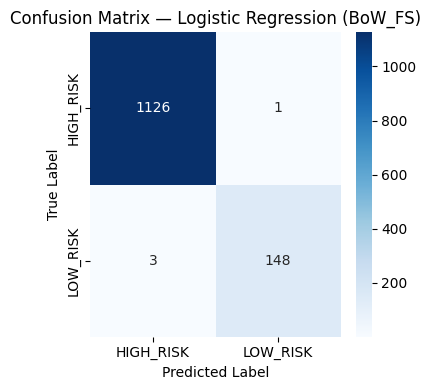

📁 Disimpan ke: /content/Result_Logistic_Regression_BoW_FS_Clinical.csv

🔹 MODEL: Naive Bayes | FITUR: BoW_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9782    0.9947    0.9864      1127
    LOW_RISK     0.9545    0.8344    0.8905       151

    accuracy                         0.9757      1278
   macro avg     0.9664    0.9146    0.9384      1278
weighted avg     0.9754    0.9757    0.9750      1278



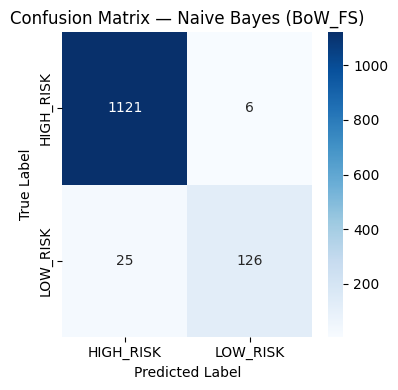

📁 Disimpan ke: /content/Result_Naive_Bayes_BoW_FS_Clinical.csv

####################################################################################################
📂 Uji model dengan fitur: TFIDF_FS

🔹 MODEL: Logistic Regression | FITUR: TFIDF_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9640    0.9991    0.9813      1127
    LOW_RISK     0.9909    0.7219    0.8352       151

    accuracy                         0.9664      1278
   macro avg     0.9775    0.8605    0.9083      1278
weighted avg     0.9672    0.9664    0.9640      1278



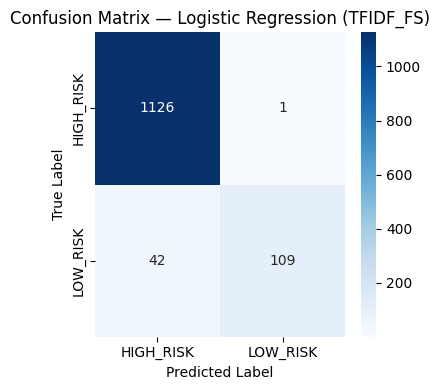

📁 Disimpan ke: /content/Result_Logistic_Regression_TFIDF_FS_Clinical.csv

🔹 MODEL: Naive Bayes | FITUR: TFIDF_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9067    1.0000    0.9511      1127
    LOW_RISK     1.0000    0.2318    0.3763       151

    accuracy                         0.9092      1278
   macro avg     0.9533    0.6159    0.6637      1278
weighted avg     0.9177    0.9092    0.8832      1278



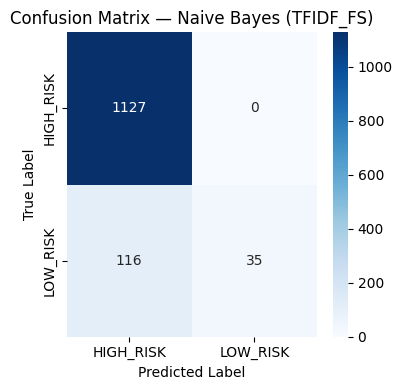

📁 Disimpan ke: /content/Result_Naive_Bayes_TFIDF_FS_Clinical.csv

####################################################################################################
📂 Uji model dengan fitur: BIGRAM_FS

🔹 MODEL: Logistic Regression | FITUR: BIGRAM_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9982    1.0000    0.9991      1127
    LOW_RISK     1.0000    0.9868    0.9933       151

    accuracy                         0.9984      1278
   macro avg     0.9991    0.9934    0.9962      1278
weighted avg     0.9984    0.9984    0.9984      1278



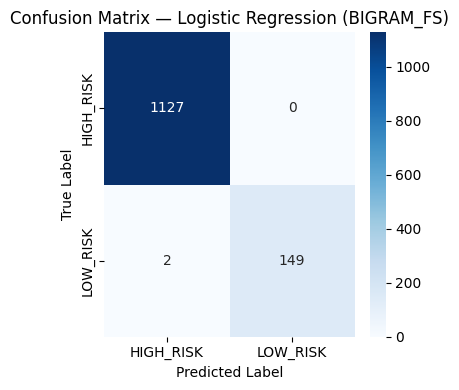

📁 Disimpan ke: /content/Result_Logistic_Regression_BIGRAM_FS_Clinical.csv

🔹 MODEL: Naive Bayes | FITUR: BIGRAM_FS

📋 Classification Report:
              precision    recall  f1-score   support

   HIGH_RISK     0.9648    0.9982    0.9812      1127
    LOW_RISK     0.9821    0.7285    0.8365       151

    accuracy                         0.9664      1278
   macro avg     0.9735    0.8634    0.9089      1278
weighted avg     0.9669    0.9664    0.9641      1278



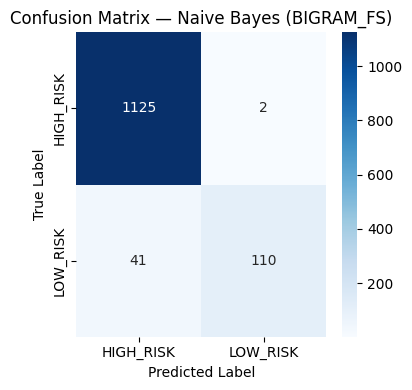

📁 Disimpan ke: /content/Result_Naive_Bayes_BIGRAM_FS_Clinical.csv


In [ ]:
# =========================================================
# 🧪 UJI MODEL — CLINICAL DATA (PAKAI FILE FEATURE SELECTION)
# =========================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# === 1️⃣ Load dataset utama ===
df = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")
y = df["label"].astype(str)
X_text = df["clean_text"].astype(str)

print(f"✅ Dataset utama dimuat: {df.shape[0]} baris")

# === 2️⃣ Load hasil feature selection ===
SET_FEATURES = {
    "BoW_FS": "/content/FS_BoW_ClinicalData.csv",
    "TFIDF_FS": "/content/FS_TFIDF_ClinicalData.csv",
    "BIGRAM_FS": "/content/FS_BIGRAM_ClinicalData.csv"
}

feature_sets = {}
for name, path in SET_FEATURES.items():
    X = pd.read_csv(path)
    feature_sets[name] = X
    print(f"• {name}: {X.shape}")

# === 3️⃣ Definisikan model yang akan diuji ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "Naive Bayes": MultinomialNB(),
}

# === 4️⃣ Uji kombinasi fitur–model ===
for feat_name, X in feature_sets.items():
    print(f"\n{'#'*100}")
    print(f"📂 Uji model dengan fitur: {feat_name}")

    X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
        X, y, X_text, test_size=0.2, random_state=42, stratify=y
    )

    for model_name, model in models.items():
        print(f"\n{'='*100}")
        print(f"🔹 MODEL: {model_name} | FITUR: {feat_name}")
        print(f"{'='*100}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # === Classification Report ===
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # === Confusion Matrix ===
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
        plt.title(f"Confusion Matrix — {model_name} ({feat_name})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

        # === Simpan hasil prediksi ===
        df_pred = pd.DataFrame({
            "text": text_test.values,
            "true_label": y_test.values,
            "predicted_label": y_pred
        })

        result_path = f"/content/Result_{model_name.replace(' ','_')}_{feat_name}_Clinical.csv"
        df_pred.to_csv(result_path, index=False, encoding="utf-8-sig")

        print(f"📁 Disimpan ke: {result_path}")


##**Deep Learning**

In [ ]:
# ===============================================================
# CLINICAL DEEP LEARNING — IMPORT & KONFIGURASI
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model
import evaluate

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

# Pakai konfigurasi LITE yang sama
MAX_WORDS = 8000
MAX_LEN   = 120
EMBED_DIM = 64

print("Konfigurasi LITE (Clinical):")
print("MAX_WORDS =", MAX_WORDS)
print("MAX_LEN   =", MAX_LEN)
print("EMBED_DIM =", EMBED_DIM)


Konfigurasi LITE (Clinical):
MAX_WORDS = 8000
MAX_LEN   = 120
EMBED_DIM = 64


In [ ]:
# Pakai konfigurasi LITE yang sama
MAX_WORDS = 8000
MAX_LEN   = 120
EMBED_DIM = 64

print("Konfigurasi LITE (Clinical):")
print("MAX_WORDS =", MAX_WORDS)
print("MAX_LEN   =", MAX_LEN)
print("EMBED_DIM =", EMBED_DIM)

Konfigurasi LITE (Clinical):
MAX_WORDS = 8000
MAX_LEN   = 120
EMBED_DIM = 64


In [ ]:
# =========================================================
# LOAD DATASET CLINICAL & ENCODE LABEL
# =========================================================

df_clin = pd.read_csv("/content/ClinicalData_with_qi_labels.csv")

assert "clean_text" in df_clin.columns
assert "label" in df_clin.columns

df_clin["clean_text"] = df_clin["clean_text"].fillna("").astype(str)

le_clin = LabelEncoder()
df_clin["label_id"] = le_clin.fit_transform(df_clin["label"])

print("Kelas (Clinical):", list(le_clin.classes_))
print(df_clin["label_id"].value_counts())

texts_clin  = df_clin["clean_text"].tolist()
labels_clin = df_clin["label_id"].tolist()

X_train_clin, X_test_clin, y_train_clin, y_test_clin = train_test_split(
    texts_clin,
    labels_clin,
    test_size=0.2,
    stratify=labels_clin,
    random_state=SEED
)

print("Train =", len(X_train_clin), " | Test =", len(X_test_clin))


Kelas (Clinical): ['HIGH_RISK', 'LOW_RISK']
label_id
0    5634
1     754
Name: count, dtype: int64
Train = 5110  | Test = 1278


In [ ]:
# =========================================================
# TOKENIZER & PADDING — CLINICAL
# =========================================================

tokenizer_clin = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token="<OOV>")
tokenizer_clin.fit_on_texts(X_train_clin)

X_train_clin_seq = pad_sequences(
    tokenizer_clin.texts_to_sequences(X_train_clin),
    maxlen=MAX_LEN,
    padding="post"
)
X_test_clin_seq = pad_sequences(
    tokenizer_clin.texts_to_sequences(X_test_clin),
    maxlen=MAX_LEN,
    padding="post"
)

y_train_clin_arr = np.array(y_train_clin)
y_test_clin_arr  = np.array(y_test_clin)

X_train_clin_seq.shape, X_test_clin_seq.shape


((5110, 120), (1278, 120))

In [ ]:
# =========================================================
# CLASS WEIGHT — CLINICAL
# =========================================================

classes_clin = np.unique(y_train_clin_arr)
cw_values_clin = compute_class_weight(
    class_weight="balanced",
    classes=classes_clin,
    y=y_train_clin_arr
)
class_weights_clin = dict(zip(classes_clin, cw_values_clin))

print("Class Weights (Clinical):", class_weights_clin)


Class Weights (Clinical): {np.int64(0): np.float64(0.5668959396494342), np.int64(1): np.float64(4.237147595356551)}


###RNN

In [ ]:
# =========================================================
# RNN (BIDIRECTIONAL) — CLINICAL (LITE)
# =========================================================

def build_rnn_clin():
    model = models.Sequential([
        layers.Input(shape=(MAX_LEN,)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.SimpleRNN(16)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(8e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

rnn_clin = build_rnn_clin()
rnn_clin.summary()

print("Training RNN (Clinical)...")
hist_rnn_clin = rnn_clin.fit(
    X_train_clin_seq,
    y_train_clin_arr,
    validation_split=0.1,
    epochs=8,
    batch_size=32,
    class_weight=class_weights_clin,
    verbose=1
)

pred_rnn_clin_prob = rnn_clin.predict(X_test_clin_seq)
pred_rnn_clin = (pred_rnn_clin_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi RNN Clinical:", np.unique(pred_rnn_clin, return_counts=True))
print(classification_report(
    y_test_clin_arr,
    pred_rnn_clin,
    target_names=le_clin.classes_,
    digits=4
))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 120, 64)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 120, 64)        │         6,208 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │         2,592 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,889 (1.99 MB)

 Trainable params: 521,889 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Training RNN (Clinical)...
Epoch 1/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.6242 - loss: 0.6662 - val_accuracy: 0.8826 - val_loss: 0.4068
Epoch 2/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8044 - loss: 0.4738 - val_accuracy: 0.9276 - val_loss: 0.2577
Epoch 3/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9121 - loss: 0.3057 - val_accuracy: 0.9315 - val_loss: 0.1978
Epoch 4/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.9452 - loss: 0.1973 - val_accuracy: 0.9295 - val_loss: 0.1811
Epoch 5/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9466 - loss: 0.1500 - val_accuracy: 0.9335 - val_loss: 0.1964
Epoch 6/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.9747 - loss: 0.0821 - val_accuracy: 0.9374 - val_loss: 0.1792
Epoch 7/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9444 - loss: 0.1402 - val_accuracy: 0.6243 - val_loss: 1.8687
Epoch 8/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accurac

###LSTM

In [ ]:
# =========================================================
# LSTM (BIDIRECTIONAL) — CLINICAL (LITE)
# =========================================================

def build_lstm_clin():
    model = models.Sequential([
        layers.Input(shape=(MAX_LEN,)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(16)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(8e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_clin = build_lstm_clin()
lstm_clin.summary()

print("Training LSTM (Clinical)...")
hist_lstm_clin = lstm_clin.fit(
    X_train_clin_seq,
    y_train_clin_arr,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    class_weight=class_weights_clin,
    verbose=1
)

pred_lstm_clin_prob = lstm_clin.predict(X_test_clin_seq)
pred_lstm_clin = (pred_lstm_clin_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi LSTM Clinical:", np.unique(pred_lstm_clin, return_counts=True))
print(classification_report(
    y_test_clin_arr,
    pred_lstm_clin,
    target_names=le_clin.classes_,
    digits=4
))


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 120, 64)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 120, 64)        │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,289 (2.09 MB)

 Trainable params: 548,289 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Training LSTM (Clinical)...
Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - accuracy: 0.8455 - loss: 0.6553 - val_accuracy: 0.9276 - val_loss: 0.2982
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.8912 - loss: 0.3265 - val_accuracy: 0.9237 - val_loss: 0.1905
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9297 - loss: 0.2097 - val_accuracy: 0.8904 - val_loss: 0.2283
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9292 - loss: 0.1693 - val_accuracy: 0.9159 - val_loss: 0.2165
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9522 - loss: 0.1305 - val_accuracy: 0.9335 - val_loss: 0.1709
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9630 - loss: 0.1033 - val_accuracy: 0.9452 - val_loss: 0.1288
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9644 - loss: 0.1047 - val_accuracy: 0.9237 - val_loss: 0.2315
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step 

###Fine Tunning

In [ ]:
# =========================================================
# FT-LSTM — CLINICAL (LITE)
# =========================================================

def to_pad_clin(texts, mlen):
    seq = tokenizer_clin.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=mlen, padding="post")

search_space_clin = [
    {"max_len": 120, "u1": 32, "u2": 16},
    {"max_len": 150, "u1": 32, "u2": 16},
]

X_train_ft_clin, X_val_ft_clin, y_train_ft_clin, y_val_ft_clin = train_test_split(
    X_train_clin, y_train_clin,
    test_size=0.1,
    stratify=y_train_clin,
    random_state=SEED
)

best_cfg_clin = None
best_acc_clin = 0.0

for cfg in search_space_clin:
    print("\nTesting config (Clinical):", cfg)
    Xtr = to_pad_clin(X_train_ft_clin, cfg["max_len"])
    Xv  = to_pad_clin(X_val_ft_clin,  cfg["max_len"])

    model = models.Sequential([
        layers.Input(shape=(cfg["max_len"],)),
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.LSTM(cfg["u1"], return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(cfg["u2"])),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    hist = model.fit(
        Xtr, np.array(y_train_ft_clin),
        validation_data=(Xv, np.array(y_val_ft_clin)),
        epochs=3,
        batch_size=32,
        class_weight=class_weights_clin,
        verbose=0
    )

    acc = max(hist.history["val_accuracy"])
    print("Best val acc:", acc)

    if acc > best_acc_clin:
        best_acc_clin = acc
        best_cfg_clin = cfg

print("\nConfig terbaik (Clinical):", best_cfg_clin)
print("Val Accuracy terbaik:", best_acc_clin)

# Train final FT-LSTM
X_train_final_clin = to_pad_clin(X_train_clin, best_cfg_clin["max_len"])
X_test_final_clin  = to_pad_clin(X_test_clin,  best_cfg_clin["max_len"])

ft_lstm_clin = models.Sequential([
    layers.Input(shape=(best_cfg_clin["max_len"],)),
    layers.Embedding(MAX_WORDS, EMBED_DIM),
    layers.Bidirectional(layers.LSTM(best_cfg_clin["u1"], return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(best_cfg_clin["u2"])),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

ft_lstm_clin.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop_clin = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

print("Training FT-LSTM final (Clinical)...")
hist_ft_clin = ft_lstm_clin.fit(
    X_train_final_clin,
    y_train_clin_arr,
    validation_split=0.1,
    epochs=8,
    batch_size=32,
    class_weight=class_weights_clin,
    callbacks=[early_stop_clin],
    verbose=1
)

pred_ft_clin_prob = ft_lstm_clin.predict(X_test_final_clin)
pred_ft_clin = (pred_ft_clin_prob >= 0.5).astype(int).flatten()

print("Distribusi prediksi FT-LSTM Clinical:", np.unique(pred_ft_clin, return_counts=True))
print(classification_report(
    y_test_clin_arr,
    pred_ft_clin,
    target_names=le_clin.classes_,
    digits=4
))



Testing config (Clinical): {'max_len': 120, 'u1': 32, 'u2': 16}
Best val acc: 0.9256359934806824

Testing config (Clinical): {'max_len': 150, 'u1': 32, 'u2': 16}
Best val acc: 0.9647749662399292

Config terbaik (Clinical): {'max_len': 150, 'u1': 32, 'u2': 16}
Val Accuracy terbaik: 0.9647749662399292
Training FT-LSTM final (Clinical)...
Epoch 1/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.7119 - loss: 0.6572 - val_accuracy: 0.9413 - val_loss: 0.3514
Epoch 2/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9540 - loss: 0.3268 - val_accuracy: 0.9667 - val_loss: 0.1422
Epoch 3/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.9650 - loss: 0.1933 - val_accuracy: 0.9276 - val_loss: 0.2100
Epoch 4/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.9789 - loss: 0.0945 - val_accuracy: 0.9785 - val_loss: 0.0853
Epoch 5/8
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.9785 - loss: 0.0803 - val_accuracy: 0.9843 - val_loss: 0.0611
Epoch 6/8
1

###LoRa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import torch
from torch.utils.data import Dataset
import numpy as np
import evaluate


In [ ]:
MODEL_NAME = "google/bert_uncased_L-2_H-128_A-2"

tokenizer_lite = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDatasetLite(Dataset):
    def __init__(self, texts, labels, tok, max_len=96):
        self.texts = texts
        self.labels = labels
        self.tok = tok
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds_lite = TextDatasetLite(X_train_clin, y_train_clin, tokenizer_lite, max_len=96)
test_ds_lite  = TextDatasetLite(X_test_clin,  y_test_clin,  tokenizer_lite, max_len=96)


In [ ]:
base_model_lite = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

lora_cfg_lite = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],
    task_type="SEQ_CLS"
)

lora_model_lite = get_peft_model(base_model_lite, lora_cfg_lite)
print("Trainable parameters:", sum(p.numel() for p in lora_model_lite.parameters()))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 4398724


In [ ]:
metric_lite = evaluate.load("accuracy")

def compute_metrics_lite(p):
    logits, labels = p
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_lite.compute(predictions=preds, references=labels)["accuracy"]
    }

training_args_lite = TrainingArguments(
    output_dir="lora_ultralite",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="no",
    report_to=[]
)

trainer_lite = Trainer(
    model=lora_model_lite,
    args=training_args_lite,
    train_dataset=train_ds_lite,
    eval_dataset=test_ds_lite,
    compute_metrics=compute_metrics_lite
)


In [ ]:
trainer_lite.train()

pred_lite = trainer_lite.predict(test_ds_lite)
y_pred_lite = np.argmax(pred_lite.predictions, axis=1)

print(classification_report(
    y_test_clin_arr,
    y_pred_lite,
    target_names=le_clin.classes_,
    digits=4
))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.276900,0.326615,0.909233
2,0.531700,0.338639,0.909233


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

   HIGH_RISK     0.9067    1.0000    0.9511      1127
    LOW_RISK     1.0000    0.2318    0.3763       151

    accuracy                         0.9092      1278
   macro avg     0.9533    0.6159    0.6637      1278
weighted avg     0.9177    0.9092    0.8832      1278



###Summary Hasil

,Accuracy,F1
RNN,0.888889,0.897177
LSTM,0.938185,0.940201
FT-LSTM,0.977308,0.976863
LoRA-BERT (ULTRA-LITE),0.909233,0.883151


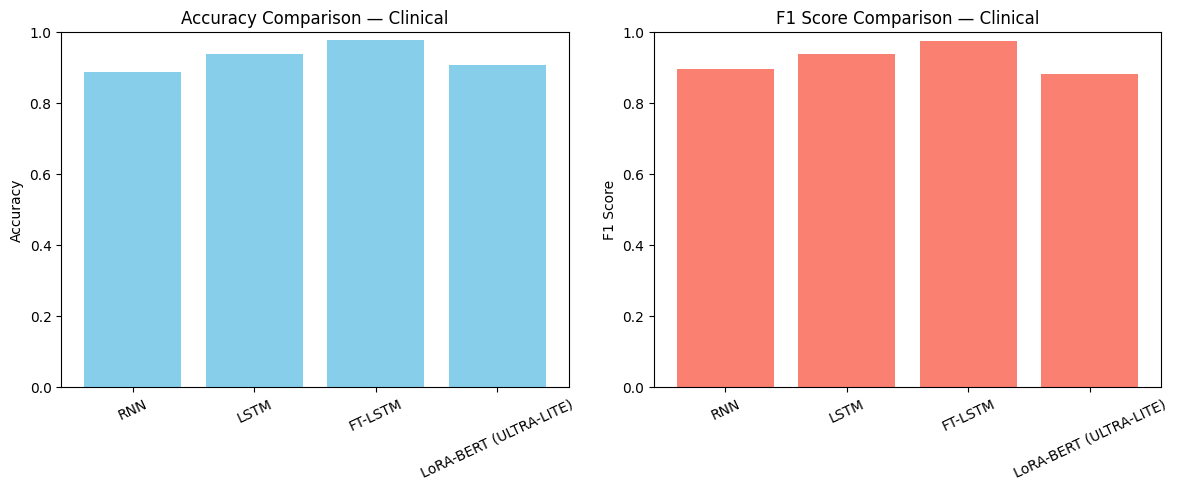

In [ ]:
# =========================================================
# 📊 SUMMARY VISUALISASI — CLINICAL
# =========================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

summary_clin = {
    "RNN": {
        "Accuracy": accuracy_score(y_test_clin_arr, pred_rnn_clin),
        "F1": f1_score(y_test_clin_arr, pred_rnn_clin, average="weighted")
    },
    "LSTM": {
        "Accuracy": accuracy_score(y_test_clin_arr, pred_lstm_clin),
        "F1": f1_score(y_test_clin_arr, pred_lstm_clin, average="weighted")
    },
    "FT-LSTM": {
        "Accuracy": accuracy_score(y_test_clin_arr, pred_ft_clin),
        "F1": f1_score(y_test_clin_arr, pred_ft_clin, average="weighted")
    },
    "LoRA-BERT (ULTRA-LITE)": {
        "Accuracy": accuracy_score(y_test_clin_arr, y_pred_lite),
        "F1": f1_score(y_test_clin_arr, y_pred_lite, average="weighted")
    }
}

# Convert to DataFrame
df_vis_clin = pd.DataFrame(summary_clin).T
display(df_vis_clin)

plt.figure(figsize=(12,5))

# ======== Accuracy ========
plt.subplot(1,2,1)
plt.bar(df_vis_clin.index, df_vis_clin["Accuracy"], color="skyblue")
plt.title("Accuracy Comparison — Clinical")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=25)

# ======== F1 Score ========
plt.subplot(1,2,2)
plt.bar(df_vis_clin.index, df_vis_clin["F1"], color="salmon")
plt.title("F1 Score Comparison — Clinical")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()


##Analisis Error

####################################################################################################
📊 Jumlah kesalahan prediksi:
   • Logistic Regression  (BoW     ) : 4 dari 1278 data (0.31%)

🔍 Contoh kesalahan prediksi — Logistic Regression (BoW):


,text,true_label,predicted_label,is_correct
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
240,pasien pria berusia 60-79 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
367,pasien caseid subjectid wanita berusia 40-59 n...,HIGH_RISK,LOW_RISK,False
890,pasien id case id laki-laki berusia 20-39 numt...,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Logistic Regression (BoW):


,Kata,Frekuensi
0,numtoken,76
1,pasien,11
2,darah,11
3,unit,11
4,mg,9
5,normal,8
6,operasi,8
7,anestesi,7
8,tersedia,7
9,menjalani,6


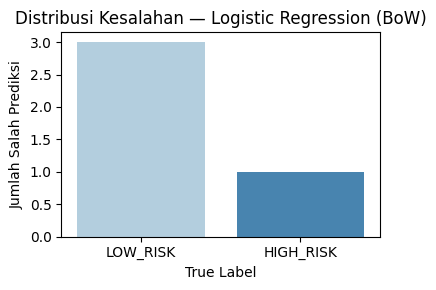

   • Logistic Regression  (TFIDF   ) : 43 dari 1278 data (3.36%)

🔍 Contoh kesalahan prediksi — Logistic Regression (TFIDF):


,text,true_label,predicted_label,is_correct
45,pasien wanita berusia 40-59 numtoken berat num...,LOW_RISK,HIGH_RISK,False
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
129,pasien id id subjek wanita berusia 60-79 numto...,HIGH_RISK,LOW_RISK,False
149,pasien id id subjek laki-laki berusia 40-59 ba...,LOW_RISK,HIGH_RISK,False
151,pasien pria berusia 40-59 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
194,pasien pria berusia 60-79 subjek id id memilik...,LOW_RISK,HIGH_RISK,False
198,pasien pria berusia 80-99 subjek id id memilik...,LOW_RISK,HIGH_RISK,False
240,pasien pria berusia 60-79 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
247,pasien id id subjek perempuan berusia 20-39 nu...,LOW_RISK,HIGH_RISK,False
260,pasien pria berusia 20-39 subjek id id memilik...,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Logistic Regression (TFIDF):


,Kata,Frekuensi
0,numtoken,884
1,pasien,169
2,operasi,146
3,mg,127
4,darah,92
5,akses,90
6,anestesi,76
7,normal,73
8,tersedia,63
9,pra-operasi,61


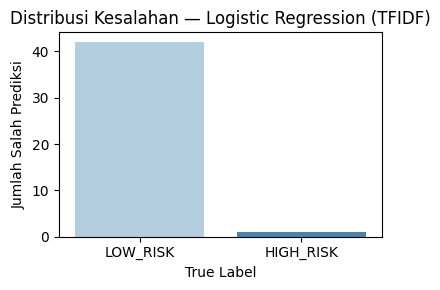

   • Logistic Regression  (BIGRAM  ) : 2 dari 1278 data (0.16%)

🔍 Contoh kesalahan prediksi — Logistic Regression (BIGRAM):


,text,true_label,predicted_label,is_correct
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
890,pasien id case id laki-laki berusia 20-39 numt...,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Logistic Regression (BIGRAM):


,Kata,Frekuensi
0,numtoken,25
1,detik,6
2,pasien,5
3,darah,5
4,dl,5
5,pra-operasi,5
6,preoperasi,4
7,normal,4
8,l,4
9,mg,4


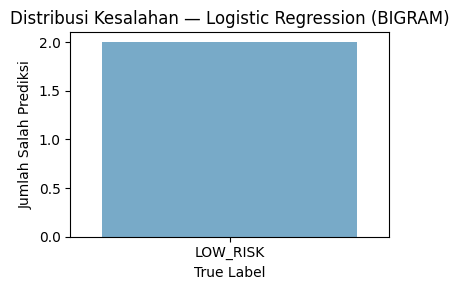

   • Naive Bayes          (BoW     ) : 31 dari 1278 data (2.43%)

🔍 Contoh kesalahan prediksi — Naive Bayes (BoW):


,text,true_label,predicted_label,is_correct
45,pasien wanita berusia 40-59 numtoken berat num...,LOW_RISK,HIGH_RISK,False
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
144,pasien subjectid caseid wanita berusia 60-79 n...,HIGH_RISK,LOW_RISK,False
151,pasien pria berusia 40-59 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
194,pasien pria berusia 60-79 subjek id id memilik...,LOW_RISK,HIGH_RISK,False
198,pasien pria berusia 80-99 subjek id id memilik...,LOW_RISK,HIGH_RISK,False
226,pasien case id subject id pria berusia 60-79 n...,HIGH_RISK,LOW_RISK,False
240,pasien pria berusia 60-79 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
260,pasien pria berusia 20-39 subjek id id memilik...,LOW_RISK,HIGH_RISK,False
319,pasien pria berusia 40-59 subjek id id memilik...,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Naive Bayes (BoW):


,Kata,Frekuensi
0,numtoken,643
1,pasien,131
2,mg,101
3,operasi,97
4,darah,74
5,anestesi,60
6,akses,59
7,normal,55
8,tersedia,45
9,hasil,44


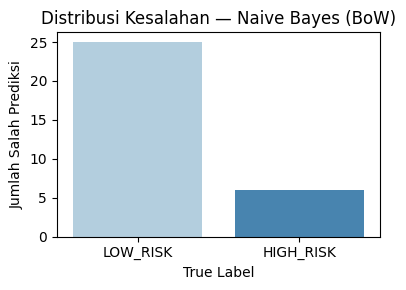

   • Naive Bayes          (TFIDF   ) : 116 dari 1278 data (9.08%)

🔍 Contoh kesalahan prediksi — Naive Bayes (TFIDF):


,text,true_label,predicted_label,is_correct
20,pasien subjek wanita berusia 60-79 numtoken be...,LOW_RISK,HIGH_RISK,False
24,pasien subjek pria berusia 60-79 numtoken bera...,LOW_RISK,HIGH_RISK,False
38,pasien subjek pria berusia 60-79 numtoken bera...,LOW_RISK,HIGH_RISK,False
45,pasien wanita berusia 40-59 numtoken berat num...,LOW_RISK,HIGH_RISK,False
67,wanita berusia 40-59 caseid subjectid numtoken...,LOW_RISK,HIGH_RISK,False
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
83,pasien caseid subjectid pria berusia 60-79 num...,LOW_RISK,HIGH_RISK,False
89,pasien id subjek pria berusia 60-79 numtoken b...,LOW_RISK,HIGH_RISK,False
106,pasien id id subjek wanita berusia 60-79 numto...,LOW_RISK,HIGH_RISK,False
121,pasien subjectid pria berusia 20-39 numtoken b...,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Naive Bayes (TFIDF):


,Kata,Frekuensi
0,numtoken,2192
1,pasien,478
2,operasi,377
3,darah,265
4,normal,204
5,anestesi,199
6,akses,194
7,mg,179
8,hasil,170
9,pra-operasi,149


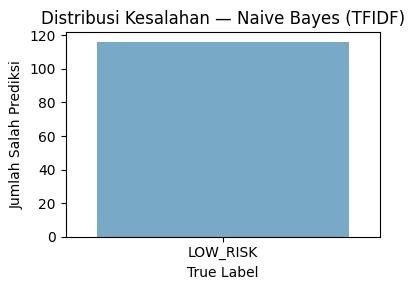

   • Naive Bayes          (BIGRAM  ) : 43 dari 1278 data (3.36%)

🔍 Contoh kesalahan prediksi — Naive Bayes (BIGRAM):


,text,true_label,predicted_label,is_correct
32,failed,LOW_RISK,HIGH_RISK,False
45,pasien wanita berusia 40-59 numtoken berat num...,LOW_RISK,HIGH_RISK,False
57,failed,LOW_RISK,HIGH_RISK,False
66,failed,LOW_RISK,HIGH_RISK,False
73,pasien wanita numtoken berat numtoken bmi stat...,LOW_RISK,HIGH_RISK,False
128,failed,LOW_RISK,HIGH_RISK,False
159,failed,LOW_RISK,HIGH_RISK,False
240,pasien pria berusia 60-79 numtoken berat numto...,LOW_RISK,HIGH_RISK,False
251,pasien subjectid pria berusia 20-39 numtoken b...,HIGH_RISK,LOW_RISK,False
266,failed,LOW_RISK,HIGH_RISK,False


📈 Kata paling sering muncul dalam prediksi salah — Naive Bayes (BIGRAM):


,Kata,Frekuensi
0,numtoken,158
1,failed,35
2,mg,34
3,pasien,23
4,darah,21
5,dl,20
6,operasi,18
7,l,16
8,normal,15
9,menjalani,12


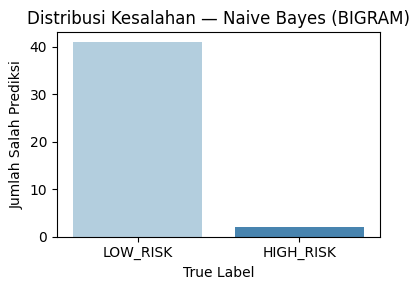


####################################################################################################

✅ Ringkasan analisis error disimpan di: /content/Error_Analysis_Summary_Clinical.csv


,Model,Fitur,Total Data Uji,Jumlah Error,Persentase Error (%)
0,Logistic Regression,BoW,1278,4,0.31
1,Logistic Regression,TFIDF,1278,43,3.36
2,Logistic Regression,BIGRAM,1278,2,0.16
3,Naive Bayes,BoW,1278,31,2.43
4,Naive Bayes,TFIDF,1278,116,9.08
5,Naive Bayes,BIGRAM,1278,43,3.36


In [ ]:
# =========================================================
# 🧠 ANALISIS ERROR — CLINICAL DATA
# =========================================================
# Analisis semua hasil uji model (BoW, TF-IDF, Bigram)
# dari Logistic Regression & Naive Bayes
# =========================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

# === 1️⃣ Daftar file hasil uji model ===
RESULT_FILES = {
    "Logistic Regression": [
        "/content/Result_Logistic_Regression_BoW_FS_Clinical.csv",
        "/content/Result_Logistic_Regression_TFIDF_FS_Clinical.csv",
        "/content/Result_Logistic_Regression_BIGRAM_FS_Clinical.csv"
    ],
    "Naive Bayes": [
        "/content/Result_Naive_Bayes_BoW_FS_Clinical.csv",
        "/content/Result_Naive_Bayes_TFIDF_FS_Clinical.csv",
        "/content/Result_Naive_Bayes_BIGRAM_FS_Clinical.csv"
    ]
}

# === 2️⃣ Fungsi bantu ===
def common_words(df, col="text", topn=15):
    """Hitung kata paling sering muncul di teks salah prediksi"""
    if col not in df.columns:
        return pd.DataFrame(columns=["Kata", "Frekuensi"])
    all_text = " ".join(df[col].astype(str).tolist()).lower().split()
    common = Counter(all_text).most_common(topn)
    return pd.DataFrame(common, columns=["Kata", "Frekuensi"])

def plot_error_distribution(df, model_name, feat_name):
    """Plot distribusi kesalahan antar label"""
    plt.figure(figsize=(4,3))
    sns.countplot(x="true_label", data=df, hue="true_label", palette="Blues", legend=False)
    plt.title(f"Distribusi Kesalahan — {model_name} ({feat_name})")
    plt.xlabel("True Label")
    plt.ylabel("Jumlah Salah Prediksi")
    plt.tight_layout()
    plt.show()

# === 3️⃣ Loop semua hasil model ===
summary_rows = []

print("#" * 100)
print("📊 Jumlah kesalahan prediksi:")

for model_name, file_list in RESULT_FILES.items():
    for path in file_list:
        if not os.path.exists(path):
            print(f"⚠️ File tidak ditemukan: {path}")
            continue

        # Ambil nama fitur dari path
        feat_name = os.path.basename(path).split("_")[3]  # BoW_FS / TFIDF_FS / BIGRAM_FS

        # Load hasil prediksi
        res = pd.read_csv(path)

        # Tambahkan kolom status benar/salah
        res["is_correct"] = res["true_label"] == res["predicted_label"]

        # Ambil data salah prediksi
        err_df = res[~res["is_correct"]]
        total = len(res)
        errors = len(err_df)
        err_percent = errors / total * 100

        print(f"   • {model_name:<20} ({feat_name:<8}) : {errors} dari {total} data ({err_percent:.2f}%)")

        summary_rows.append({
            "Model": model_name,
            "Fitur": feat_name,
            "Total Data Uji": total,
            "Jumlah Error": errors,
            "Persentase Error (%)": round(err_percent, 2)
        })

        # === Contoh kesalahan ===
        print(f"\n🔍 Contoh kesalahan prediksi — {model_name} ({feat_name}):")
        if "text" in err_df.columns:
            display(err_df.head(10)[["text", "true_label", "predicted_label", "is_correct"]])
        else:
            print("ℹ️ Kolom 'text' tidak ditemukan. Menampilkan label saja.\n")
            display(err_df.head(10)[["true_label", "predicted_label", "is_correct"]])

        # === Kata paling sering muncul di prediksi salah ===
        print(f"📈 Kata paling sering muncul dalam prediksi salah — {model_name} ({feat_name}):")
        common_df = common_words(err_df, col="text", topn=15)
        display(common_df)

        # === Plot distribusi kesalahan ===
        if not err_df.empty:
            plot_error_distribution(err_df, model_name, feat_name)

print("\n" + "#" * 100)

# === 4️⃣ Simpan ringkasan keseluruhan ===
summary = pd.DataFrame(summary_rows)
summary_path = "/content/Error_Analysis_Summary_Clinical.csv"
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")

print(f"\n✅ Ringkasan analisis error disimpan di: {summary_path}")
display(summary)
